In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy


import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer 

import autocorrect as autocorrect
from autocorrect import Speller
from num2words import num2words 
from spellchecker import SpellChecker

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn import svm

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, space_eval

import gensim
from gensim.models import word2vec



import string
pd.options.display.html.use_mathjax = False

%matplotlib inline

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Letting Americans Tell Us What They Think of Politicians *In their Own Words*:
### Using Natural Language Processing to Explore and Analyze Americans' Responses to Open-Ended Survey Questions About What They Like and Dislike About Presidential Candidates.
### Matt Childers, Ph.D.
#### Thinkful Data Science Final Capstone Project

#### The Problem: We Frequently Ask People Why They Vote The Way They Do, But We Rarely Let Them Tell Us In Their Own Words

We have decades of social science research where we have used surveys to measure peoples' political preferences and their underlying causes. It has established many pieces of conventional wisdom that are being recycled during this election cycle. Here are a few examples:
- [Elections are always about the "fundamentals:" the economy and foreign policy](https://press.princeton.edu/books/paperback/9780691139630/the-message-matters). 
- Voters prefer the candidate who is [idelogically "closest" to them](https://en.wikipedia.org/wiki/An_Economic_Theory_of_Democracy).
- While [partisanship is a primary factor in our decision](https://books.google.com/books?hl=en&lr=&id=JeYUrs_GOcMC&oi=fnd&pg=PA18&ots=wGiABGZpyd&sig=Pk8h_tOzQF83LbYLFrLkiM_WWkc#v=onepage&q&f=false), on the margins our [elections are referendas](https://en.wikipedia.org/wiki/An_Economic_Theory_of_Democracy) [on the incumbent](https://www.journals.uchicago.edu/doi/10.1086/694396).

I do not mean to imply that these claims are wrong. But, almost all surveys use closed-ended questions, which structure peoples' thought processes and limit their response choices. Thus, analysts may miss insights into respondents' attitudes because they are unable to get a glimpse into someone's thought process.



#### The Solution: Asking Voters to Tell Us In Their Own Words and Using NLP to Analyze Their Answers

*For this project*, I will analyze responses to open-ended questions in surveys that ask Americans why they support or oppose the two major party presidential candidates. Open-ended questions allow survey respondents to answer questions in their own words without limiting their choices or structuring their thought processes. They give us a window into how people [structure their thoughts and how they associate topics and ideas that closed-ended questions are unable to do](https://pdfs.semanticscholar.org/e14e/39956665a6dbaaad7559842f171f37ad52b1.pdf). They are especially superior [measures when we do not know the full spectrum of potential answers](https://calgara.github.io/Pol157_Spring2019/Pasek%20&%20Krosnick%202010.pdf). 

I want to accomplish the following goals in the analysis:
- Investigate common terms and concepts that the public associates with opposing candidates.
- Build a model to classify the sentiment of peoples' evaluations.
- Use topic modeling to investigate how ideas, beliefs, and judgments organically cluster together in peoples' judgments.

#### The data

The data are from the 2008, 2012, 2016 [American National Election Studies](https://electionstudies.org) (ANES). The ANES is the most widely used survey of voting behavior and has been conducted in every presidential year since 1948 by the University of Michigan. It is currently co-managed by Stanford University and is funded by the National Science Foundation. 

The survey has historically been conducted in person with representative national samples between 1200-2400 respondents. In recent years, the ANES has supplemented in person interviews with an online sample that is also randomly selected. For the latter, the ANES uses the same sampling procedures as the face to face (FTF) sample, recruiting respondents with letters with $5 cash enclosed and promises of payments if they fill out the survey. ANES follows up with with prospective respondents who did not agree to take the survey with offers of higher payments to complete it. Members of the in person sample are paid 20 percent more than online respondents. The 2016 survey sample included 1,180 FTF interviews and 3090 online. For more information, please see the [User's Guide and Codebook](https://electionstudies.org/data-center/2016-time-series-study/). 

Towards the beginning of the survey, the interviewer asks the respondent a set of open-ended questions about what would let them to support or oppose each of the two major party presidential candidates. They are commonly referred to as the candidate "likes" and "dislikes."  For an example from 2016, they asked: "Is there anything about Hillary Clinton that might make you want to vote for her?" If the respondent says yes, the interviewer asks them to elaborate and records everything that they say. If the respondent only offers one thought (which can be just a few words or a long sentence), the interviewer will ask them if there is anything else that they would like to add. They would then ask the respondent if there was anything that would make them want to vote against her and if they answer affirmatively, they again allow the respondent to speak freely. Afterwards, interviewer asks the same questions about Donald Trump. They record the conversation and transcribe the respondent's statements as they speak, but the ANES staff also listen to the recording at a later date to make sure that their transcripts captured everything. To reduce potential bias from question ordering, the survey randomizes the order of the candidates. 

The likes and dislikes have been a part of every ANES survey since 1952, but survey managers have not made the transcripts available to researchers until 2008. In those years, staff would codify respondents' statements, matching up to five sentences in each response to generic statements that they had created over the years. For example, code 101 reads, "traditional Democratic voter: always been a Democrat; just a Democrat; never been a Republican; just couldn't vote Republican." Staff would then further aggregate codes to a set of twelve categories (party characteristics, issues-domestic, issues-foreign, candidate-personal, candidate-experience, etc.).  

In the years between the 2004 and 2008 surveys, ANES principal investigators (PI's) discovered inconsistencies in ANES's instructions to interviewers and other staff about how they code respondents' statements. Instructions had changed over time, as well as the coding process, prompting the PIs to conduct an investigation into past studies. After a lengthy process, they concluded that research using those variables should not be considered null and void, but they would create a new set of "master codes" that would be applied to every survey going forward. They would also attempt to updates past surveys with the new coding system recode. In the meantime, they would release redacted versions of the likes and dislikes going forward so scholars could decide how to code the variables on their own. The general public now has access to the 2008, 2012, and 2016 transcripts. 

The research that has used the data from the three most recent survey years has replicated the old approach. Scholars have used the old coding as a guide. Google Scholar searches shows that there is not yet any peer-reviewed published work using natural language processing to analyze the transcripts. 

Since the survey is federally funded, the data are freely available to the public. Some information that would allow a researcher to identify the individual is withheld from the public release. Researchers may apply for special access to some, but not all, of the confidential information. For example, respondent's zip codes are kept from the public version, but researchers may apply to use them (and pay a heavy application fee). 

#### The Value

The data are potentially a gold mine of insights into how voters evaluate politicians that researchers have not yet been able to systematically explore. We may uncover patterns in the transcripts that closed-ended questions have missed. Even though these are about presidential candidates, we may uncover patterns that are generalizable beyond presidential elections, to down ballot races where it is too costly to conduct frequent telephone surveys.

Most state and local campaigns historically have not had the resources to use surveys with open-ended questions, but today's technology gives us a chance to change that. High quality telephone surveys cost at least $21 per completed interview (at academic institutions that operate without a profit-motive) and can cost as much as $49 with reputable pollsters. Thus, for a sample of 800, a survey can cost between almost $17,000 to $39,200. They typically do not include open-ended questions, otherwise they would cost much, much more. High quality online surveys typically cost between $5,000 to $10,000 for a similar sample size (closed-ended questions only). 

We can build supervised learning models to classify the sentiment of peoples' statements that we can apply to "new" text from the 2020 elections when those transcripts are released. We can also apply the models to transcripts from election focus groups covering the same ground that are funded by major news outlets and subsequently released. We can also use topic modeling techniques to see how ideas and attitudes organically cluster together, potentially providing us with insights about how to codify respondents's answers. The ANES spends tens of thousands of dollars on teams of staff members that pour through thousands of transcripts deciding how each statement should be coded. Topic models can potentially do that for us at a small fraction of the cost in a small fraction of the time. 

Thus, state and local candidates, even most congressional candidates could then potentially use these techniques to inform their electoral strategies, getting a leg up on their opponents. Politicians, political parties, and consultants are always looking for new ways to market themselves or their allies in ways to give them an electoral advantage. We can use NLP to analyze the likes and dislikes to provide products that can open new avenues for how politicians interact with their constituents. The answers we find may point to ways we can engineer features to combine with others from the rest of the survey to make better predictions about voter sentiment and voter preferences. 

#### Pulling the Data Together

The redacted open-ended responses are available in Excel spreadsheets that are separate from the survey datasets. Before we clean and explore the transcripts, we should read in all of the data, pull the other survey features that might prove useful in the supervised learning section, merge everything together, and then prep the data. 

The ANES labels variables in different ways from survey to survey over time. I renamed the open-ended variable names and the respondent ID column upon reading the data into Pandas. The ANES documentation is available at their [website's data page](https://electionstudies.org/data-center/).

In [2]:
# Read in open ended comments
# each of the names in the names series is like or dislike variable 
# See ANES documentation.

openends2016 = pd.read_excel('/Users/machilders/Box Sync/Data Science/Thinkful/Data Files/anes_timeseries_2016/anes2016_openends.xlsx',
                         names = ['caseid', 'dclikes', 'dcdlikes', 'rclikes', 'rcdlikes'])

openends2012 = pd.read_excel('/Users/machilders/Box Sync/Data Science/Thinkful/Data Files/anes_timeseries_2012/anes_timeseries_2012_openends.xlsx', 
                             sheet_name = 'comments', 
                             names = ['caseid', 'dclikes', 'dcdlikes', 'rclikes', 'rcdlikes'])

openends2008 = pd.read_excel('/Users/machilders/Box Sync/Data Science/Thinkful/Data Files/anes_timeseries_2008/anes_timeseries_2008_openends_redacted_Dec2012Revision.xls',
                            sheet_name = 'cand_likesdislikes', names = ['caseid', 'dclikes', 'dcdlikes', 'rclikes', 'rcdlikes'])

In [3]:
# Reading in the rest of the survey data.

anes2016 = pd.read_csv('/Users/machilders/Box Sync/Data Science/Thinkful/Data Files/anes_timeseries_2016/anes_timeseries_2016_rawdata.txt', 
                       sep = '|', usecols = ['V160001_orig', 'V161158x', 'V160501', 'V161267', 'V161270', 'V161342', 'V161004'])

anes2012 = pd.read_csv('/Users/machilders/Box Sync/Data Science/Thinkful/Data Files/anes_timeseries_2012/anes_timeseries_2012_rawdata.txt',
                      sep = '|', 
                       usecols = ['caseid', 'mode', 'pid_x', 'dem_age_r_x', 'dem_edu', 'gender_respondent_x', 'interest_following'])

anes2008 = pd.read_csv('/Users/machilders/Box Sync/Data Science/Thinkful/Data Files/anes_timeseries_2008/anes_timeseries_2008_rawdata.txt',
                      sep = '|', 
                      usecols = ['V080001', 'V082009', 'V083098x', 'V083217', 'V081104', 'V083311', 'V083001a'])

In [4]:
# Checking to see if the data were read in correctly.

anes2012.head()

,caseid,mode,gender_respondent_x,interest_following,pid_x,dem_age_r_x,dem_edu
0,1,1,2,1,1,86,3
1,2,1,1,1,1,79,4
2,3,1,2,1,1,72,10
3,4,1,2,2,1,54,10
4,5,1,1,1,3,35,9


In [5]:
# Checking the 2012 ANES information

anes2012.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5914 entries, 0 to 5913
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   caseid               5914 non-null   int64
 1   mode                 5914 non-null   int64
 2   gender_respondent_x  5914 non-null   int64
 3   interest_following   5914 non-null   int64
 4   pid_x                5914 non-null   int64
 5   dem_age_r_x          5914 non-null   int64
 6   dem_edu              5914 non-null   int64
dtypes: int64(7)
memory usage: 323.5 KB


In [6]:
# Creating an id variable for each dataframe that will take take the year and add the 
# original caseid. 

anes2016['rid'] = '2016' + anes2016['V160001_orig'].astype(str)
anes2012['rid'] = '2012' + anes2012['caseid'].astype(str)
anes2008['rid'] = '2008' + anes2008['V080001'].astype(str)

In [7]:
# Doing the same in the open-ended responses file for each year

openends2016['rid'] = '2016' + openends2016['caseid'].astype(str)
openends2012['rid'] = '2012' + openends2012['caseid'].astype(str)
openends2008['rid'] = '2008' + openends2008['caseid'].astype(str)

In [8]:
# Checking to see that everything went smoothly. 

openends2016.head()

,caseid,dclikes,dcdlikes,rclikes,rcdlikes,rid
0,300001,NaN,everything,truth//his caring for the country,NaN,2016300001
1,300002,NaN,seem corptupt anti gun anti 2nd amen,pro 2nd amendement//,erassional//,2016300002
2,300003,NaN,NaN,NaN,NaN,2016300003
3,300004,NaN,whole personal//no,he says what he thinks//I believe he will do w...,arganize,2016300004
4,300006,NaN,Im not really strong on their policies and tha...,NaN,dont feel he has political experience//,2016300006


In [9]:
anes2016.head()

# Looks like we created the variable correctly

,V160001_orig,V160501,V161004,V161158x,V161267,V161270,V161342,rid
0,300001,1,1,7,29,9,1,2016300001
1,300002,1,1,6,26,13,1,2016300002
2,300003,1,3,3,23,9,1,2016300003
3,300004,1,2,5,58,9,1,2016300004
4,300006,1,2,3,38,9,2,2016300006


In [10]:
openends2012.head()

,caseid,dclikes,dcdlikes,rclikes,rcdlikes,rid
0,1,NaN,NaN,NaN,NaN,20121
1,2,"try to bring coubtry tofwthwr, creaet jobs,trt...",NaN,NaN,"47 persxent flip foppibg, likes truthful speaking",20122
2,3,"He has qulification to be a leader, things he ...",NaN,NaN,Everthing not qualified to be a leader of the ...,20123
3,4,"tried to help people with insurance,",NaN,NaN,NaN,20124
4,5,His vision for the way our government should l...,NaN,He comes across as he could be a leader.// No,"His social views, his tax plan view on educati...",20125


In [11]:
openends2008.head()

,caseid,dclikes,dcdlikes,rclikes,rcdlikes,rid
0,1,NaN,"higher taxes, his possible picks for supreme c...",tough on the war on terror,his immigration policies,20081
1,2,NaN,refused to answer,"nothing in peticular, R just knows that she do...",NaN,20082
2,3,his family,fear of liberal values,"General Republican values, anti abortion, mili...","typical politician, says one thing does another",20083
3,4,NaN,"his inexperience, and his views on taxes","his views more or less on politics, R feels he...",he feels he is for sending military overseas f...,20084
4,5,NaN,some of his back ground and loyalties - R has ...,"same reason R would vote agains Obama, R likes...",His age,20085


In [12]:
# Let's create a year column in each dataset to give us the potential to 
# keep track of variation over time

anes2016['year'] = 2016
anes2012['year'] = 2012
anes2008['year'] = 2008

In [13]:
anes2016.head()

,V160001_orig,V160501,V161004,V161158x,V161267,V161270,V161342,rid,year
0,300001,1,1,7,29,9,1,2016300001,2016
1,300002,1,1,6,26,13,1,2016300002,2016
2,300003,1,3,3,23,9,1,2016300003,2016
3,300004,1,2,5,58,9,1,2016300004,2016
4,300006,1,2,3,38,9,2,2016300006,2016


##### PID

I will define someone as partisan if they admit to considering themself as a member of one of the parties (either strongly or weakly) or whether they admitted to leaning towards one of the parties despite being Independent. The partisanship variable is constructed after asking a series of questions about respondents' partisan affiliation. The ANES begins by asking whether they consider themselves as Democrats, Republicans, Independents, or apolitical. If they are Independent, the survey probes whether they learn towards either of the parties and to identify which one. 

In [14]:
# Creating a summary party id variable
# 2016

# Democrat, values 1-3, Strong Dem, Weak Dem, Independent who leans
# Dem
anes2016.loc[(anes2016['V161158x'] >=1) & (anes2016['V161158x'] <=3), 'pid'] = 1

# Republican, values 5-7, Strong Republican, Weak Republican, 
# Republican-leaning Independent

anes2016.loc[(anes2016['V161158x'] >= 5) & (anes2016['V161158x'] <= 7), 'pid'] = 2

# Independent
anes2016.loc[anes2016['V161158x'] == 4, 'pid'] = 3

# Don't Know
anes2016.loc[anes2016['V161158x'] == -8, 'pid'] = 4

# Refused
anes2016.loc[anes2016['V161158x'] == -9, 'pid'] = 4

In [15]:
# Creating a summary party id variable, 2012


# Democrat, values 1-3, Strong Dem, Weak Dem, Independent who leans
# Dem
anes2012.loc[(anes2012['pid_x'] >=1) & (anes2012['pid_x'] <=3), 'pid'] = 1

# Republican, values 5-7, Strong Republican, Weak Republican, 
# Republican-leaning Independent

anes2012.loc[(anes2012['pid_x'] >= 5) & (anes2012['pid_x'] <= 7), 'pid'] = 2

# Independent
anes2012.loc[anes2012['pid_x'] == 4, 'pid'] = 3

# Missing
anes2012.loc[anes2012['pid_x'] == -2, 'pid'] = 4

In [16]:
# Creating a summary party id variable, 2008


# Democrat, values 1-3, Strong Dem, Weak Dem, Independent who leans
# Dem
anes2008.loc[(anes2008['V083098x'] >=0) & (anes2008['V083098x'] <=2), 'pid'] = 1

# Republican, values 5-7, Strong Republican, Weak Republican, 
# Republican-leaning Independent

anes2008.loc[(anes2008['V083098x'] >= 4) & (anes2008['V083098x'] <= 6), 'pid'] = 2

# Independent
anes2008.loc[anes2008['V083098x'] == 3, 'pid'] = 3

# Missing
anes2008.loc[anes2008['V083098x'] == -1, 'pid'] = 4

In [17]:
pd.crosstab(anes2008['V083098x'], anes2008.pid)

pid,1.0,2.0,3.0,4.0
V083098x,,,,
-1,0,0,0,40
0,580,0,0,0
1,393,0,0,0
2,392,0,0,0
3,0,0,264,0
4,0,223,0,0
5,0,200,0,0
6,0,230,0,0


##### Education

In [18]:
# Recoding education variable, 2016

# Refused
anes2016.loc[anes2016['V161270'] == -9, 'education'] = -9

# Other, not specified
anes2016.loc[anes2016['V161270'] == 95, 'education'] = -8

# Completed middle school or less
anes2016.loc[(anes2016['V161270'] >= 1) & (anes2016['V161270'] <= 4), 'education'] = 1

# Less than high school
anes2016.loc[(anes2016['V161270'] >= 5) & (anes2016['V161270'] <= 8), 'education'] = 2

# Graduated high school
anes2016.loc[(anes2016['V161270'] == 9) | (anes2016['V161270'] == 90), 'education'] = 3

# Some college or Associate's degree
anes2016.loc[(anes2016['V161270'] >= 10) & (anes2016['V161270'] <=  12), 'education'] = 4

# College Degree
anes2016.loc[anes2016['V161270'] == 13, 'education'] = 5

# Masters Degree
anes2016.loc[anes2016['V161270'] == 14, 'education'] = 6

# Doctoral Level
anes2016.loc[(anes2016['V161270'] == 15) | (anes2016['V161270'] == 16), 'education'] = 7

In [19]:
# Recoding Education Variable, 2012

# Refused
anes2012.loc[anes2012['dem_edu'] == -9, 'education'] = -9

# Other, not specified
anes2012.loc[anes2012['dem_edu'] == 95, 'education'] = -8

# Completed middle school or less
anes2012.loc[(anes2012['dem_edu'] >= 1) & (anes2012['dem_edu'] <= 4), 'education'] = 1

# Less than high school
anes2012.loc[(anes2012['dem_edu'] >= 5) & (anes2012['dem_edu'] <= 8), 'education'] = 2

# Graduated high school
anes2012.loc[(anes2012['dem_edu'] == 9) | (anes2012['dem_edu'] == 90), 'education'] = 3

# Some college or Associate's degree
anes2012.loc[(anes2012['dem_edu'] >= 10) & (anes2012['dem_edu'] <=  12), 'education'] = 4

# College Degree
anes2012.loc[anes2012['dem_edu'] == 13, 'education'] = 5

# Masters Degree
anes2012.loc[anes2012['dem_edu'] == 14, 'education'] = 6

# Doctoral Level
anes2012.loc[(anes2012['dem_edu'] == 15) | (anes2012['dem_edu'] == 16), 'education'] = 7

In [20]:
# Recoding Education Variable, 2008

# Refused
anes2008.loc[anes2008['V083217'] == -9, 'education'] = -9

# Other, not specified
anes2008.loc[anes2008['V083217'] == 95, 'education'] = -8

# Completed middle school or less
anes2008.loc[(anes2008['V083217'] >= 1) & (anes2008['V083217'] <= 4), 'education'] = 1

# Less than high school
anes2008.loc[(anes2008['V083217'] >= 5) & (anes2008['V083217'] <= 8), 'education'] = 2

# Graduated high school
anes2008.loc[(anes2008['V083217'] == 9) | (anes2008['V083217'] == 90), 'education'] = 3

# Some college or Associate's degree
anes2008.loc[(anes2008['V083217'] >= 10) & (anes2008['V083217'] <=  12), 'education'] = 4

# College Degree
anes2008.loc[anes2008['V083217'] == 13, 'education'] = 5

# Masters Degree
anes2008.loc[anes2008['V083217'] == 14, 'education'] = 6

# Doctoral Level
anes2008.loc[(anes2008['V083217'] == 15) | (anes2008['V083217'] == 16) | (anes2008['V083217'] == 17) , 'education'] = 7

In [21]:
anes2008.V083217.value_counts()

 12    725
 14    328
 16    289
 13    244
 17    243
 11    128
 15    104
 10     85
 9      58
 8      42
 6      26
 7      12
 5      10
-9       8
 3       7
 4       5
 1       3
-8       2
 0       2
 2       1
Name: V083217, dtype: int64

In [22]:
# Let's look at a crosstab to see if everything went smoothly

pd.crosstab(anes2008.V083217, anes2008.education)

education,-9.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
V083217,,,,,,,,
-9,8,0,0,0,0,0,0,0
1,0,3,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0
3,0,7,0,0,0,0,0,0
4,0,5,0,0,0,0,0,0
5,0,0,10,0,0,0,0,0
6,0,0,26,0,0,0,0,0
7,0,0,12,0,0,0,0,0
8,0,0,42,0,0,0,0,0


##### Age

In [23]:
# 2016
# V161267, the variable measuring age in years for adults, has a value of 6, which does 
# not make sense given that the survey interviews adults aged 18 or older, or people
# 17 years-old who will be 18 on election day.
# Let's convert the 6 to -6
# -8 and -9 are refused or not specified 

anes2016['age'] = anes2016['V161267']
anes2016.loc[anes2016['V161267'] == 6, 'age'] = -6

In [24]:
pd.crosstab(anes2012.dem_age_r_x, columns = 'counts')

col_0,counts
dem_age_r_x,
-2,60
17,2
18,43
19,61
20,77
...,...
86,14
87,8
88,7


In [25]:
# 2012
# dem_age_r_x, the variable measuring age in years for adults, 
# has some people with a  -2,
# which is likely a missing value, or people

anes2012['age'] = anes2012['dem_age_r_x']

In [26]:
# Creating a contingency table to look at the variable's distribution.
# This keeps the values in order, whereas vale_counts() sorts the 
# values by frequency. 

pd.crosstab(anes2008.V081104, columns = 'counts')

col_0,counts
V081104,
-9,19
-8,3
17,3
18,31
19,29
...,...
86,7
87,9
88,4


In [27]:
#2008

anes2008['age'] = anes2008['V081104']

##### Gender

In [28]:
# 2016

# Recoding self-identified gender
# If you cross-check this with ANES codebook, the marginals do not 
# match. The ANES website does not have any updates on it in their 
# "Updates & Errata" page.

# Male
anes2016.loc[anes2016['V161342'] == 1, 'gender'] = 1

# Female
anes2016.loc[anes2016['V161342'] == 2, 'gender'] = 2

# Other
anes2016.loc[anes2016['V161342'] == 3, 'gender'] = 3

# Not specified or refused
anes2016.loc[(anes2016['V161342'] == 6) | (anes2016['V161342'] == -9), 'gender'] = -1

In [29]:
# 2012

anes2012['gender'] = anes2012['gender_respondent_x']

In [30]:
# 2008

anes2008['gender'] = anes2008['V083311']

##### Mode of Interview

In [31]:
anes2016['mode'] = anes2016['V160501']
anes2008['mode'] = anes2008['V082009']

##### Interest (Interest in the Campaign)

In [32]:
anes2016.V161004.value_counts()

1    2230
2    1519
3     521
Name: V161004, dtype: int64

In [33]:
# 2016

# Not much interested
anes2016.loc[anes2016['V161004'] == 3, 'interest'] = 1

# Somewhat interested
anes2016.loc[anes2016['V161004'] == 2, 'interest'] = 2

# Very much interested
anes2016.loc[anes2016['V161004'] == 1, 'interest'] = 3

In [34]:
# 2012

# Not much interested
anes2012.loc[anes2012['interest_following'] == 3, 'interest'] = 1

# Somewhat interested
anes2012.loc[anes2012['interest_following'] == 2, 'interest'] = 2

# Very much interested
anes2012.loc[anes2012['interest_following'] == 1, 'interest'] = 3

# Don't Know or Refused

anes2012.loc[(anes2012['interest_following'] == -8) | (anes2012['interest_following'] == -9), 'interest'] = 0


In [35]:
# Checking the distribution of the campaign interest variable from
# 2008. The ANES tested a new version of the question and I would like
# to use the original version. I want to make sure that I'm using the 
# right version. 

pd.crosstab(anes2008.V083001a, columns = 'counts')

col_0,counts
V083001a,
-1,1144
1,528
3,474
5,176


In [36]:
# 2008

# Not much interested
anes2008.loc[anes2008['V083001a'] == 5, 'interest'] = 1

# Somewhat interested
anes2008.loc[anes2008['V083001a'] == 3, 'interest'] = 2

# Very much interested
anes2008.loc[anes2008['V083001a'] == 1, 'interest'] = 3

# Don't Know or Refused

anes2008.loc[anes2008['V083001a'] == -1, 'interest'] = 0

#### Pulling and Prepping Survey Features

In [37]:
# Merging each year's survey with its open-ended data from the 
# other file

anes2016_full = pd.merge(anes2016, openends2016, how = 'left', on = 'rid')
anes2012_full = pd.merge(anes2012, openends2012, how = 'left', on = 'rid')
anes2008_full = pd.merge(anes2008, openends2008, how = 'left', on = 'rid')

In [38]:
anes2008_full.head()

,V080001,V081104,V082009,V083001a,V083098x,V083217,V083311,rid,year,pid,education,age,gender,mode,interest,caseid,dclikes,dcdlikes,rclikes,rcdlikes
0,1,34,1,1,4,13,1,20081,2008,2.0,5.0,34,1,1,3.0,1,NaN,"higher taxes, his possible picks for supreme c...",tough on the war on terror,his immigration policies
1,2,58,1,5,0,12,2,20082,2008,1.0,4.0,58,2,1,1.0,2,NaN,refused to answer,"nothing in peticular, R just knows that she do...",NaN
2,3,39,1,-1,5,16,2,20083,2008,2.0,7.0,39,2,1,0.0,3,his family,fear of liberal values,"General Republican values, anti abortion, mili...","typical politician, says one thing does another"
3,4,49,1,5,3,12,1,20084,2008,3.0,4.0,49,1,1,1.0,4,NaN,"his inexperience, and his views on taxes","his views more or less on politics, R feels he...",he feels he is for sending military overseas f...
4,5,72,1,1,6,16,1,20085,2008,2.0,7.0,72,1,1,3.0,5,NaN,some of his back ground and loyalties - R has ...,"same reason R would vote agains Obama, R likes...",His age


In [39]:
# Concatenating all of them to create one large dataset.

anes_nlp = pd.concat([anes2008_full, anes2012_full, anes2016_full])

Let's check for missing data in the pooled dataset. As we see below, four columns have a lot of missing rows. These are the open-ended response variables. 

In [40]:
# Let's keep the columns that we want to work with

anes_nlp = anes_nlp[['rid', 'year', 'age', 'pid', 'education', 'gender', 'interest', 'mode', 'dclikes', 'dcdlikes', 'rclikes', 'rcdlikes']]

In [41]:
anes_nlp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12506 entries, 0 to 4269
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rid        12506 non-null  object 
 1   year       12506 non-null  int64  
 2   age        12506 non-null  int64  
 3   pid        12506 non-null  float64
 4   education  12502 non-null  float64
 5   gender     12506 non-null  float64
 6   interest   12506 non-null  float64
 7   mode       12506 non-null  int64  
 8   dclikes    8598 non-null   object 
 9   dcdlikes   8217 non-null   object 
 10  rclikes    7275 non-null   object 
 11  rcdlikes   9382 non-null   object 
dtypes: float64(4), int64(3), object(5)
memory usage: 1.2+ MB


The dataset has 12,506 observations over three surveys. The comments columns, which I have named *dclikes*, *dcdlikes*, *rclikes*, and *rcdlikes* are: 
- *dclikes* are positive considerations of the Democratic Party's presidential nominee
- *dcdlikes* are negative considerations of the Democratic Party's nominee
- *rclikes* are positive considerations of the Republican Party's presidential nominee
- *rcdlikes* are negative consideration of the Republican Party's nominee

We can also see that not every person answered the open-ended questions. Almost 42% of those surveyed neglected to offer answers on one of them, which raises concerns about whether the responses to these questions are representative of the public's thoughts of the candidates. As I will show, most people answer at least one of the two candidate questions.  

In [42]:
anes_nlp.isnull().sum()/anes_nlp.isnull().count()*100

rid           0.000000
year          0.000000
age           0.000000
pid           0.000000
education     0.031985
gender        0.000000
interest      0.000000
mode          0.000000
dclikes      31.249000
dcdlikes     34.295538
rclikes      41.827923
rcdlikes     24.980010
dtype: float64

In [43]:
# Had positive and negative comment(s) about Democratic Candidate
anes_nlp.loc[(anes_nlp['dclikes'].notnull()) & (anes_nlp['dcdlikes'].notnull()), 'dcambivalence'] = 3

# Only positive about them
anes_nlp.loc[(anes_nlp['dclikes'].notnull()) & (anes_nlp['dcdlikes'].isnull()), 'dcambivalence'] = 2

# Only negative about them
anes_nlp.loc[(anes_nlp['dclikes'].isnull()) & (anes_nlp['dcdlikes'].notnull()), 'dcambivalence'] = 1

# No comments about the candidate, positive or negative
anes_nlp.loc[(anes_nlp['dclikes'].isnull()) & (anes_nlp['dcdlikes'].isnull()), 'dcambivalence'] = 0

In [44]:
# Had positive and negative about Republican Candidate
anes_nlp.loc[(anes_nlp['rclikes'].notnull()) & (anes_nlp['rcdlikes'].notnull()), 'rcambivalence'] = 3

# Only positive about them
anes_nlp.loc[(anes_nlp['rclikes'].notnull()) & (anes_nlp['rcdlikes'].isnull()), 'rcambivalence'] = 2

# Only negative about them
anes_nlp.loc[(anes_nlp['rclikes'].isnull()) & (anes_nlp['rcdlikes'].notnull()), 'rcambivalence'] = 1

# No comments about the candidate, positive or negative
anes_nlp.loc[(anes_nlp['rclikes'].isnull()) & (anes_nlp['rcdlikes'].isnull()), 'rcambivalence'] = 0

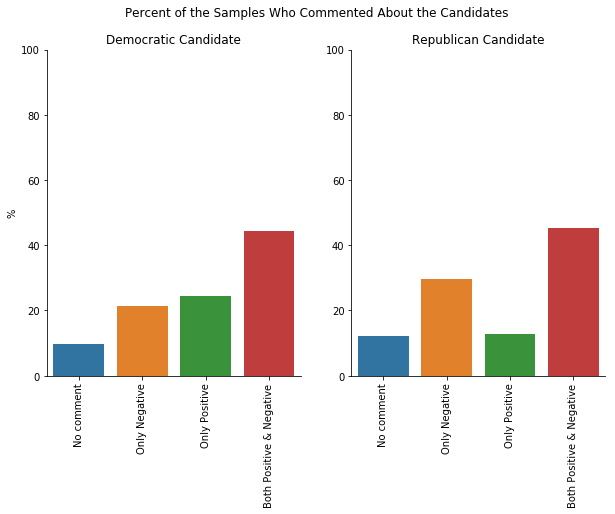

In [45]:
plt.figure(figsize = (10, 6))

plt.suptitle('Percent of the Samples Who Commented About the Candidates')


plt.subplot(1, 2, 1)
sns.barplot(x = 'dcambivalence', y = 'dcambivalence', data = anes_nlp, 
            estimator = lambda x: len(x) / len(anes_nlp) * 100)
plt.ylim(0,100)
plt.ylabel('%')
plt.xticks(np.arange(4), ('No comment', 'Only Negative', 'Only Positive', 'Both Positive & Negative'),
          rotation = 90)
plt.xlabel('')
plt.title('Democratic Candidate')
sns.despine()

plt.subplot(1, 2, 2)
sns.barplot(x = 'rcambivalence', y = 'rcambivalence', data = anes_nlp, 
            estimator = lambda x: len(x) / len(anes_nlp) * 100)
plt.ylim(0,100)
plt.ylabel('')
plt.xticks(np.arange(4), ('No comment', 'Only Negative', 'Only Positive', 'Both Positive & Negative'),
          rotation = 90)
plt.xlabel('')
plt.title('Republican Candidate')
sns.despine()

plt.show()

We can also delete the other dataframes since we are no longer using them.

In [46]:
del openends2008
del openends2012
del openends2016
del anes2008
del anes2012
del anes2016
del anes2016_full
del anes2012_full
del anes2008_full

#### Cleaning the Text

Before we proces the text, let's review the language for the open-ended candidate questions. This one is about Hillary Clinton from 2016, but the one about Donald Trump is identical (as are questions from previous years).
- "Is there anything in particular about Hillary Clinton that might make you want to vote for her?" If the person answers yes, the interviewer will ask, "What is that?" After the respondent finishes, the interviewer follows up with, "Is there anything else?" They are instructed to continue to probe the respondent until the respondent has nothing else to add. From the interviewer instructions: "PROBE: ANYTHING ELSE? UNTIL R SAYS NO."
- The same questions are asked about the Republican candidate. As I noted above, the survey randomizes the order of the candidates to mitigate question order bias. 
- With the exception of the candidates' names, the question language is identical each year. 

The text responses are provided in four columns containing positive and negative considerations for each candidate, respectively. Each cell in the four response columns contains raw text of the ANES's transcriptions of the respondent's statements, except for confidential information. The ANES redacts terms or phrases can help identify the respondent as well as statements about commercial enterprises (for example, if the respondent refers to a well known corporation like Coca-Cola, it is redacted). 

The transcripts are full of sentence fragments that need to be cleaned up before analysis, as well as spelling and grammatical errors. Since some respondents did not answer one of the questions, we need to convert NAN's to empty strings. Here is an example of comments from each of the four columns that were in the 2016 survey:
- "She has experience, she is rational...the alternative is not//I think she'd be a good president//I mean.. I have a [REDACTED FAMILY DETAILS] so I think having a woman president would be a positive role model!" (V161069)
- "no intergrity, [REDACTED FOOD PRODUCTION COMPANY] got a tax breakk, pay for play//sold 20 percet of our land Uranian to stock pile// destroyed emails , federal records which is a felony, and if had pneumonia why visits grandkids instead of hospital//" (V161072)
- "I believe his immagration, it makes sense//the you know needing to check people who are coming into this country. They need to be checked out relly well//and also the gun control// they need to really check that out, you know, investigate it//They really need to thouroughly check and find out about how they feel about the United states of America// wondering why people go back and forth with all the terrorism now//He made some good points//"
- "Everything about him. I don't trust him. I don't think he has any clue about American public people need and has no idea what it takes to be president and no clue on issues of national concerns. //I think he's a poor representation of what America stands for. What we are trying to be as a nation for ourselves and in the world, in the global, the world.//" (V161078)
 

Do people really speak in sentence fragments? Yes, when they get tough questions that force them to deliberate on the spot. Open-ended questions require [more cognitive effort](https://pdfs.semanticscholar.org/e14e/39956665a6dbaaad7559842f171f37ad52b1.pdf) than closed-ended questions. Since people are doing this in an interview, they are also thinking out loud. 

The spelling and grammatical errors are likely due to a couple of possibilities: the interviewers were typing quickly to make sure they caught people's whole statements and the online respondents were probably typing quickly to complete the survey without worrying about spelling, grammatical, or punctuation errors. Some sentences end with a period and some end with "//"'s, "\\"'s, or single forward or backward slashes. ANES documentation does not provide a key for symbols or other special characters. I replaced the back- and foward slashes with periods. 

Most statements are not as verbose as this. Rather, a more typical response to any of the candidate questions ranges from a sentence fragment to a complete sentence.

In [47]:
# First, let's convert all NaN's to empty strings. 

anes_nlp['dclikes'].fillna('', inplace = True)
anes_nlp['dcdlikes'].fillna('', inplace = True)
anes_nlp['rclikes'].fillna('', inplace = True)
anes_nlp['rcdlikes'].fillna('', inplace = True)

cols = ['dclikes', 'dcdlikes', 'rclikes', 'rcdlikes']

for col in cols:
    # converting dtype to string. This is going to convert all NaN's to 
    anes_nlp[col] = anes_nlp[col].astype(str)
    
   
    # lowercase string 'nan''s.
    anes_nlp[col] = anes_nlp[col].str.lower()
    

We also need to also remove forward and backslashes and a number of terms that a stop words library did not detect in some preliminary processing. I used NLTK's stop words library to filter them out, but for some reason the helper function missed a number of "he's" and "she's" and also "hes" and "shes" because they were in statements immediately following an ellipsis (...) or two periods (is..he's or is..hes or is...hes or is...he's, for example). My hunch is the function saw this as one word and it therefore did not remove them. 

I also am replacing the most commonly misspelled words with their correct spelling. This is admittedly more tedious than using a spell checking utility, but I tested three popular packages without much success. Each one corrected many misspelled words, but it also made many mistakes that changed the meaning of entire statements. For example, 'errasional' was replaced with erosional. "Barrack Obama" was changed to barack drama. I ultimately decided to not use a spell checker and replace the most common misspellings manually. These words were among the 10-20 most common words in Bag of Words models that I used for the exploratory analysis. 

In [48]:
# Replacing forward and backsplashes from each of the four text columns

# dclikes
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace("\\", ". ")
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace("//", ". ")
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace("/", ". ")
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace("he's", "")
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace("hes", "")
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace("she's", '')
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace("shes", '')
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace("dont", '')
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('bengazi', 'benghazi')
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('lair', 'liar')
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('2nd amen ', 'second amendment')
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('2nd amend ', 'second amendment')
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('2nd', 'second')
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('erassional', 'irrational')
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('arganize', 'organize')
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('democrative', 'democratic')
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('dont', "don't")
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('doesnt', "doesn't")
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('pillary', "hillary")

# In 2012, the ANES entered #-1 inapplicable" in the rows of respondents
# who did not answer the question. 

anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('-1 inapplicable', " ")
anes_nlp['dclikes'] = anes_nlp['dclikes'].str.replace('barrack', "barack")


# dcdlikes
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace("\\", ". ")
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace("//", ". ")
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace("/", ". ")
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace("he's", "")
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace("hes", "")
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace("she's", '')
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace("shes", '')
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace("dont", '')
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace("bengazi", 'benghazi')
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace("lair", 'liar')
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace('2nd amen ', 'second amendment')
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace('2nd amend ', 'second amendment')
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace('2nd', 'second')
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace('erassional', 'irrational')
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace('arganize', 'organize')
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace('democrative', 'democratic')
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace('pillary', "hillary")
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace('-1 inapplicable', " ")
anes_nlp['dcdlikes'] = anes_nlp['dcdlikes'].str.replace('barrack', "barack")

# rclikes
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('\\', '. ')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('//', '. ')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('/', '. ')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace("he's", '')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace("hes", '')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace("she's", '')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace("shes", '')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace("dont", '')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace("bengazi", 'benghazi')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace("lair", 'liar')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('2nd amen ', 'second amendment')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('2nd amend ', 'second amendment')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('2nd', 'second')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('erassional', 'irrational')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('arganize', 'organize')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('democrative', 'democratic')
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('pillary', "hillary")
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('-1 inapplicable', " ")
anes_nlp['rclikes'] = anes_nlp['rclikes'].str.replace('barrack', 'barack')

# rcdlikes
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('\\', '. ')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('//', '. ')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('/', '. ')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace("he's", '. ')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace("hes", '. ')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace("she's", '')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace("shes", '')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace("dont", '')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace("bengazi", 'benghazi')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace("lair", 'liar')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('2nd amen ', 'second amendment')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('2nd amend ', 'second amendment')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('2nd', 'second')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('erassional', 'irrational')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('arganize', 'organize')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('democrative', 'democratic')
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('pillary', "hillary")
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('-1 inapplicable', " ")
anes_nlp['rcdlikes'] = anes_nlp['rcdlikes'].str.replace('barrack', 'barack')

In [49]:
# Let's create a categorical variable for pid

anes_nlp.loc[anes_nlp['pid'] == 1, 'pid_label'] = 'Democrat'
anes_nlp.loc[anes_nlp['pid'] == 2, 'pid_label'] = 'Republican'
anes_nlp.loc[anes_nlp['pid'] == 3, 'pid_label'] = 'Independent'
anes_nlp.loc[anes_nlp['pid'] == 4, 'pid_label'] = "Refused/Don't Know"

In [50]:
pd.crosstab(anes_nlp['pid_label'], columns = 'counts', margins = True)

col_0,counts,All
pid_label,,
Democrat,6407,6407
Independent,1635,1635
Refused/Don't Know,87,87
Republican,4377,4377
All,12506,12506


##### Loquacity

We know that Americans tend to be ignorant about a lot of what goes on in politics. Unsurprisingly, from perusing the transcripts, some respondents only offer one to a few words (if they say anything at all) while others offer a long paragraph's worth of thoughts. I will begin by counting the number of words that people say and then I'll count the number of statements that they offer. 

###### By Party

About half of respondents did not offer responses to the open-ended likes and dislikes questions (or at least failed to answer one of the four). For each of the questions, looking at those who did offer a response, the average length of responses varied by partisanship. Members of the candidate's party were more loquacious in praising their party's nominee than the opposition party or independents and while we see the opposite with the opposition party. They were more talkative in criticizing the other party's nominee than other partisans. This is not surprising becuase partisans tend to get angrier and more anxious over everything the opposing party's candidate does and [fear and negativity tend to engage people more than positive, reassuring messages](https://www.press.uchicago.edu/ucp/books/book/chicago/A/bo3636531.html). 

#### Creating Columns Measuring Loquacity 

In [51]:
# creating columns measuring the number of words in each column

cols = ['dclikes', 'dcdlikes', 'rclikes', 'rcdlikes']

for col in cols:
    anes_nlp['len' + col] = anes_nlp[col].str.split().str.len()

In [52]:
anes_nlp.head()

,rid,year,age,pid,education,gender,interest,mode,dclikes,dcdlikes,rclikes,rcdlikes,dcambivalence,rcambivalence,pid_label,lendclikes,lendcdlikes,lenrclikes,lenrcdlikes
0,20081,2008,34,2.0,5.0,1.0,3.0,1,,"higher taxes, his possible picks for supreme c...",tough on the war on terror,his immigration policies,1.0,3.0,Republican,0,16,6,3
1,20082,2008,58,1.0,4.0,2.0,1.0,1,,refused to answer,"nothing in peticular, r just knows that she do...",,1.0,2.0,Democrat,0,3,13,0
2,20083,2008,39,2.0,7.0,2.0,0.0,1,his family,fear of liberal values,"general republican values, anti abortion, mili...","typical politician, says one thing does another",3.0,3.0,Republican,2,4,7,7
3,20084,2008,49,3.0,4.0,1.0,1.0,1,,"his inexperience, and his views on taxes","his views more or less on politics, r feels he...",he feels he is for sending military overseas f...,1.0,3.0,Independent,0,7,17,25
4,20085,2008,72,2.0,7.0,1.0,3.0,1,,some of his back ground and loyalties - r has ...,"same reason r would vote agains obama, r likes...",his age,1.0,3.0,Republican,0,44,54,2


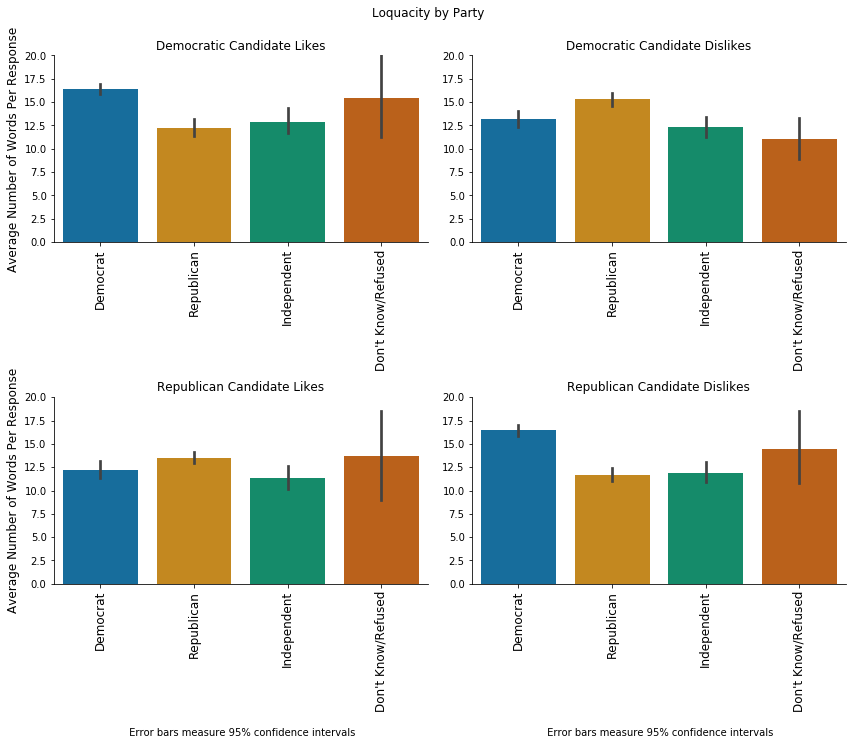

In [53]:
# Plotting the loquacity columns

plt.figure(figsize = (12, 10))
plt.suptitle('Loquacity by Party', y = 1.03)

plt.subplot(2, 2, 1)
sns.barplot(x = 'pid', y = 'lendclikes', data = anes_nlp[anes_nlp['lendclikes'] > 0], ci = 95, palette = 'colorblind')
plt.ylim(0,20)
plt.xticks(np.arange(4), ('Democrat', 'Republican', 'Independent', "Don't Know/Refused"),
           fontsize = 12, rotation = 90)
plt.ylabel('Average Number of Words Per Response', fontsize = 12)
plt.xlabel('')
sns.despine()
plt.title("Democratic Candidate Likes")

plt.subplot(2, 2, 2)
sns.barplot(x = 'pid', y = 'lendcdlikes', data = anes_nlp[anes_nlp['lendcdlikes'] > 0], ci = 95, palette = 'colorblind')
plt.ylim(0,20)
plt.xticks(np.arange(4), ('Democrat', 'Republican', 'Independent', "Don't Know/Refused"),
           fontsize = 12, rotation = 90)
plt.ylabel('')
plt.xlabel('')
sns.despine()
plt.title("Democratic Candidate Dislikes")

plt.subplot(2, 2, 3)
sns.barplot(x = 'pid', y = 'lenrclikes', data = anes_nlp[anes_nlp['lenrclikes'] > 0], ci = 95, palette = 'colorblind')
plt.ylim(0,20)
plt.xticks(np.arange(4), ('Democrat', 'Republican', 'Independent', "Don't Know/Refused"), fontsize = 12,
           rotation = 90)
plt.ylabel('Average Number of Words Per Response', fontsize = 12)
plt.xlabel('\n Error bars measure 95% confidence intervals')
sns.despine()
plt.title("Republican Candidate Likes")

plt.subplot(2, 2, 4)
sns.barplot(x = 'pid', y = 'lenrcdlikes', data = anes_nlp[anes_nlp['lenrcdlikes'] > 0], ci = 95, palette = 'colorblind')
plt.ylim(0,20)
plt.xticks(np.arange(4), ('Democrat', 'Republican', 'Independent', "Don't Know/Refused"), 
           fontsize = 12, rotation = 90)
plt.ylabel('')
plt.xlabel('\n Error bars measure 95% confidence intervals')
sns.despine()
plt.title("Republican Candidate Dislikes")

plt.tight_layout()
plt.show()

We should also check to see how response length by mode of interview since we have over twice as many web respondents as we have in person. I don't have any clear expectations about whether face-to-face (FTF) of online respondents will say more than the other. FTF respondents are making less effort since they are speaking and someone is recording their answers. People taking it online have to type their answers, which requires more effort. On the other hand, FTF respondents are not answering the questions in private, which could cause some of them to clam up.

As we see below, FTF's answers are about five times longer than online respondents. 

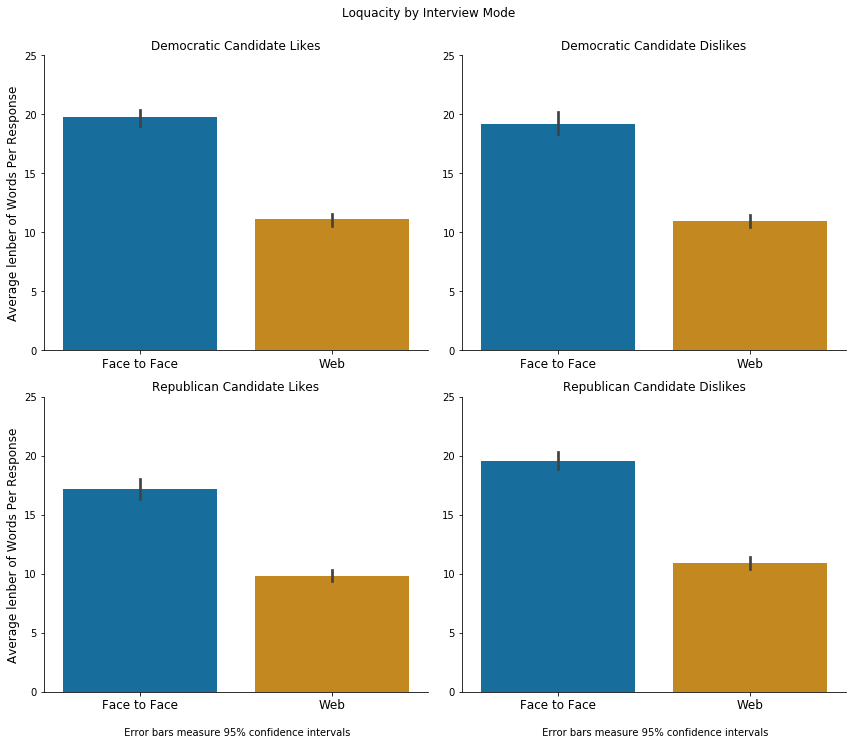

In [54]:
# Verbosity by Interview Mode

plt.figure(figsize = (12, 10))
plt.suptitle('Loquacity by Interview Mode', y = 1.03)

plt.subplot(2, 2, 1)
sns.barplot(x = 'mode', y = 'lendclikes', data = anes_nlp[anes_nlp['lendclikes'] > 0], ci = 95, palette = 'colorblind')
plt.ylim(0,25)
plt.xticks(np.arange(2), ('Face to Face', 'Web'), fontsize = 12)
plt.ylabel('Average lenber of Words Per Response', fontsize = 12)
plt.xlabel('')
sns.despine()
plt.title("Democratic Candidate Likes")

plt.subplot(2, 2, 2)
sns.barplot(x = 'mode', y = 'lendcdlikes', data = anes_nlp[anes_nlp['lendcdlikes'] > 0], ci = 95, palette = 'colorblind')
plt.ylim(0,25)
plt.xticks(np.arange(2), ('Face to Face', 'Web'), fontsize = 12)
plt.ylabel('')
plt.xlabel('')
sns.despine()
plt.title("Democratic Candidate Dislikes")

plt.subplot(2, 2, 3)
sns.barplot(x = 'mode', y = 'lenrclikes', data = anes_nlp[anes_nlp['lenrclikes'] > 0], ci = 95, palette = 'colorblind')
plt.ylim(0,25)
plt.xticks(np.arange(2), ('Face to Face', 'Web'), fontsize = 12)
plt.ylabel('Average lenber of Words Per Response', fontsize = 12)
plt.xlabel('\n Error bars measure 95% confidence intervals')
sns.despine()
plt.title("Republican Candidate Likes")

plt.subplot(2, 2, 4)
sns.barplot(x = 'mode', y = 'lenrcdlikes', data = anes_nlp[anes_nlp['lenrcdlikes'] > 0], ci = 95, palette = 'colorblind')
plt.ylim(0,25)
plt.xticks(np.arange(2), ('Face to Face', 'Web'), fontsize = 12)
plt.ylabel('')
plt.xlabel('\n Error bars measure 95% confidence intervals')
sns.despine()
plt.title("Republican Candidate Dislikes")

plt.tight_layout()
plt.show()

#### Counting Considerations

Another way to measure how deeply people have thought about the candidates is counting their thoughts, i.e. counting the number of sentences in their responses. To get a sense of how much they are informed about both candidates, we should sum their sentences across all four columns, totalling their total number of "likes" and "dislikes" for both candidates. We will look at the total considerations across age, gender, political interest, interview mode, and education. Political science [research](https://onlinelibrary.wiley.com/doi/10.1111/j.1468-2508.2007.00615.x) shows that all of those features have positive relationships with Americans' cognitive engagement in politics. 

To make that feasible, we will first use Spacy to segment responses into sentences. Then, we will create variables counting the sentences in each of the response columns and then create a column totaling the sentences across the response columns. 

In [55]:
# Loading Spacy's English model

nlp = spacy.load('en')

In [56]:
# Using Spacy to segment responses into sentences

anes_nlp['dclikes_sents'] = anes_nlp['dclikes'].apply(lambda x: [sent for sent in nlp(x).sents])
anes_nlp['dcdlikes_sents'] = anes_nlp['dcdlikes'].apply(lambda x: [sent for sent in nlp(x).sents])
anes_nlp['rclikes_sents'] = anes_nlp['rclikes'].apply(lambda x: [sent for sent in nlp(x).sents])
anes_nlp['rcdlikes_sents'] = anes_nlp['rcdlikes'].apply(lambda x: [sent for sent in nlp(x).sents])

In [57]:
# Creating columns counting the number of sentences in each person's response

anes_nlp['numdclikes'] = anes_nlp['dclikes_sents'].apply(lambda x: len(x))
anes_nlp['numdcdlikes'] = anes_nlp['dcdlikes_sents'].apply(lambda x: len(x))

anes_nlp['numrclikes'] = anes_nlp['rclikes_sents'].apply(lambda x: len(x))
anes_nlp['numrcdlikes'] = anes_nlp['rcdlikes_sents'].apply(lambda x: len(x))

In [58]:
# Create a column summing the sentence counts

anes_nlp['total_considerations'] = anes_nlp[['numdclikes', 'numdcdlikes', 'numrclikes', 'numrcdlikes']].sum(axis=1)

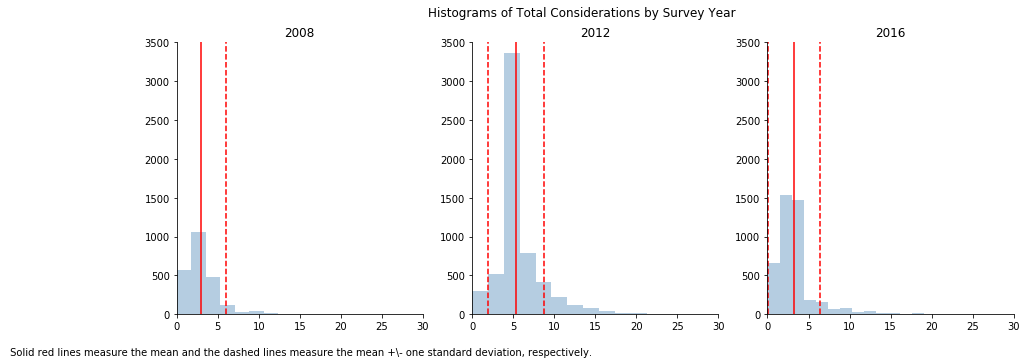

In [59]:
plt.figure(figsize = (15, 5))
plt.suptitle('Histograms of Total Considerations by Survey Year')

plt.subplot(1, 3, 1)
sns.distplot(anes_nlp[anes_nlp['year'] == 2008]['total_considerations'], color = 'steelblue', kde = False, bins = 30)
plt.xlim(0,30)
plt.xlabel('\n Solid red lines measure the mean and the dashed lines measure the mean +\- one standard deviation, respectively.')
plt.ylim(0, 3500)
plt.title('2008')
plt.axvline(anes_nlp[anes_nlp['year'] == 2008]['total_considerations'].mean(), color = 'red', linestyle = 'solid')
plt.axvline(anes_nlp[anes_nlp['year'] == 2008]['total_considerations'].mean() - anes_nlp[anes_nlp['year'] == 2008]['total_considerations'].std(), color = 'red', linestyle = 'dashed')
plt.axvline(anes_nlp[anes_nlp['year'] == 2008]['total_considerations'].mean() + anes_nlp[anes_nlp['year'] == 2008]['total_considerations'].std(), color = 'red', linestyle = 'dashed')
sns.despine()

plt.subplot(1, 3, 2)
sns.distplot(anes_nlp[anes_nlp['year'] == 2012]['total_considerations'], color = 'steelblue', kde = False, bins = 30)
plt.xlim(0,30)
plt.xlabel('')
plt.ylim(0, 3500)
plt.title('2012')
plt.axvline(anes_nlp[anes_nlp['year'] == 2012]['total_considerations'].mean(), color = 'red', linestyle = 'solid')
plt.axvline(anes_nlp[anes_nlp['year'] == 2012]['total_considerations'].mean() - anes_nlp[anes_nlp['year'] == 2012]['total_considerations'].std(), color = 'red', linestyle = 'dashed')
plt.axvline(anes_nlp[anes_nlp['year'] == 2012]['total_considerations'].mean() + anes_nlp[anes_nlp['year'] == 2012]['total_considerations'].std(), color = 'red', linestyle = 'dashed')

plt.subplot(1, 3, 3)
sns.distplot(anes_nlp[anes_nlp['year'] == 2016]['total_considerations'], color = 'steelblue', kde = False, bins = 30)
plt.xlim(0,30)
plt.xlabel('')
plt.ylim(0, 3500)
plt.title('2016')
plt.axvline(anes_nlp[anes_nlp['year'] == 2016]['total_considerations'].mean(), color = 'red', linestyle = 'solid')
plt.axvline(anes_nlp[anes_nlp['year'] == 2016]['total_considerations'].mean() - anes_nlp[anes_nlp['year'] == 2016]['total_considerations'].std(), color = 'red', linestyle = 'dashed')
plt.axvline(anes_nlp[anes_nlp['year'] == 2016]['total_considerations'].mean() + anes_nlp[anes_nlp['year'] == 2016]['total_considerations'].std(), color = 'red', linestyle = 'dashed')
sns.despine()

plt.show()

ANES respondents had fewer things to say about the candidates in 2008 and 2016 than they did in 2012, which is consistent with political science research. [People are less familiar with candidates in open seat elections than they are with incumbents who are running for reelection](https://rowman.com/ISBN/9781538123416/The-Politics-of-Congressional-Elections-Tenth-Edition). When incumbents are running for reelection, voters are more certain about the future because they they have observed their behavior over the past two or four years, whereas [uncertainty is much higher in open-seat elections because the candidates have not held that role before](https://www.jstor.org/stable/10.1017/s002238161000054x?seq=1). Thus, the public should have an easier time judging candidates in elections with incumbents than in open seat elections. 

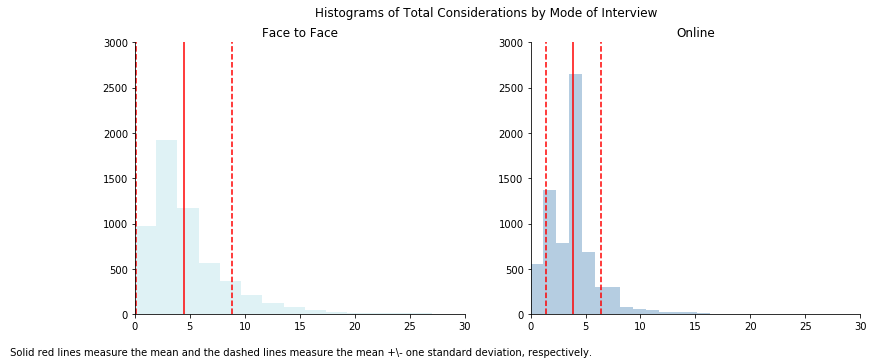

In [60]:
plt.figure(figsize = (13, 5))
plt.suptitle('Histograms of Total Considerations by Mode of Interview')

plt.subplot(1, 2, 1)
sns.distplot(anes_nlp[anes_nlp['mode'] == 1]['total_considerations'], color = 'powderblue', kde = False, bins = 30)
plt.xlim(0,30)
plt.xlabel('\n Solid red lines measure the mean and the dashed lines measure the mean +\- one standard deviation, respectively.')
plt.ylim(0, 3000)
plt.title('Face to Face')
plt.axvline(anes_nlp[anes_nlp['mode'] == 1]['total_considerations'].mean(), color = 'red', linestyle = 'solid')
plt.axvline(anes_nlp[anes_nlp['mode'] == 1]['total_considerations'].mean() - anes_nlp[anes_nlp['mode'] == 1]['total_considerations'].std(), color = 'red', linestyle = 'dashed')
plt.axvline(anes_nlp[anes_nlp['mode'] == 1]['total_considerations'].mean() + anes_nlp[anes_nlp['mode'] == 1]['total_considerations'].std(), color = 'red', linestyle = 'dashed')
sns.despine()

plt.subplot(1, 2, 2)
sns.distplot(anes_nlp[anes_nlp['mode'] == 2]['total_considerations'], color = 'steelblue', kde = False, bins = 30)
plt.xlim(0,30)
plt.xlabel('')
plt.ylim(0, 3000)
plt.title('Online')
plt.axvline(anes_nlp[anes_nlp['mode'] == 2]['total_considerations'].mean(), color = 'red', linestyle = 'solid')
plt.axvline(anes_nlp[anes_nlp['mode'] == 2]['total_considerations'].mean() - anes_nlp[anes_nlp['mode'] == 2]['total_considerations'].std(), color = 'red', linestyle = 'dashed')
plt.axvline(anes_nlp[anes_nlp['mode'] == 2]['total_considerations'].mean() + anes_nlp[anes_nlp['mode'] == 2]['total_considerations'].std(), color = 'red', linestyle = 'dashed')


sns.despine()

plt.show()


The plots above show histograms of the total considerations that respondents had about both candidates. Face to face respondents also had more considerations, on average, than online respondents. The distribution for Face to Face interviewees had greater variance than the distribution for the onlien sample. 

In [61]:
# Creating an age group colunn to make an age-related plot intuitive

anes_nlp.loc[(anes_nlp['age'] == -9) | (anes_nlp['age'] == -9), 'age_group'] = 0
anes_nlp.loc[(anes_nlp['age'] >= 17) & (anes_nlp['age'] <= 24), 'age_group'] = 1
anes_nlp.loc[(anes_nlp['age'] >= 25) & (anes_nlp['age'] <= 34), 'age_group'] = 2
anes_nlp.loc[(anes_nlp['age'] >= 35) & (anes_nlp['age'] <= 44), 'age_group'] = 3
anes_nlp.loc[(anes_nlp['age'] >= 45) & (anes_nlp['age'] <= 54), 'age_group'] = 4
anes_nlp.loc[(anes_nlp['age'] >= 55) & (anes_nlp['age'] <= 64), 'age_group'] = 5
anes_nlp.loc[(anes_nlp['age'] >= 65) & (anes_nlp['age'] <= 74), 'age_group'] = 6
anes_nlp.loc[anes_nlp['age'] >= 75, 'age_group'] = 7

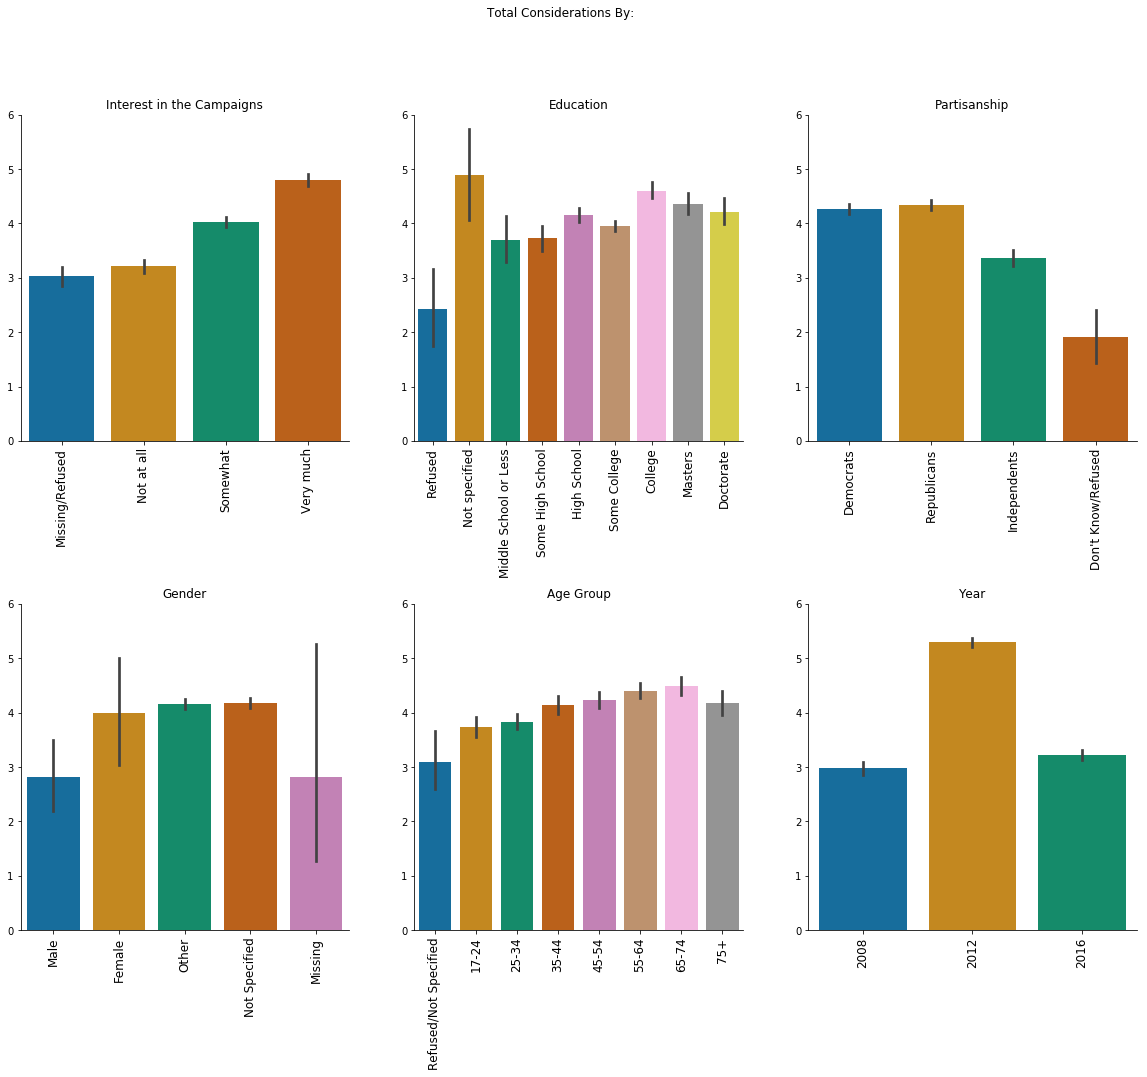

In [62]:
plt.figure(figsize = (20, 15))

plt.suptitle('Total Considerations By:', fontsize = 12)

plt.subplots_adjust(hspace = .5)

plt.subplot(2, 3, 1)
sns.barplot(x = 'interest', y = 'total_considerations', data = anes_nlp,
           palette = 'colorblind')
plt.ylabel('')
plt.ylim(0, 6)
plt.xlabel('')
plt.xticks(np.arange(4), ('Missing/Refused', 'Not at all', 'Somewhat', 'Very much'), rotation = 90, fontsize = 12)

plt.title('Interest in the Campaigns', fontsize = 12)
sns.despine()


plt.subplot(2, 3, 2)
sns.barplot(x = 'education', y = 'total_considerations', data = anes_nlp,
           palette = 'colorblind')
plt.ylabel('')
plt.ylim(0, 6)
plt.xlabel('')
plt.xticks(np.arange(9), ('Refused', 'Not specified', 'Middle School or Less', 
                          'Some High School', 'High School', 'Some College', 'College',
                          'Masters', 'Doctorate'), rotation = 90, fontsize = 12)

plt.title('Education', fontsize = 12)
sns.despine()



plt.subplot(2, 3, 3)
sns.barplot(x = 'pid', y = 'total_considerations', data = anes_nlp,
           palette = 'colorblind')
plt.ylabel('')
plt.ylim(0, 6)
plt.xlabel('')
plt.xticks(np.arange(4), ('Democrats', 'Republicans', 'Independents', 
                         "Don't Know/Refused"), rotation = 90, fontsize = 12)

plt.title('Partisanship', fontsize = 12)
sns.despine()


plt.subplot(2, 3, 4)
sns.barplot(x = 'gender', y = 'total_considerations', data = anes_nlp,
           palette = 'colorblind')
plt.ylabel('')
plt.ylim(0,6)
plt.xlabel('')
plt.xticks(np.arange(5), ('Male', 'Female', 'Other', 'Not Specified', 'Missing'), rotation = 90, fontsize = 12)
plt.title('Gender', fontsize = 12)
sns.despine()

plt.subplot(2, 3, 5)

sns.barplot(x = 'age_group', y = 'total_considerations', data = anes_nlp,
           palette = 'colorblind')
plt.ylabel('')
plt.ylim(0,6)
plt.xlabel('')
plt.xticks(np.arange(8), ('Refused/Not Specified', '17-24', '25-34', '35-44',
                         '45-54', '55-64', '65-74', '75+'), rotation = 90,  fontsize = 12)

plt.title('Age Group',  fontsize = 12)
sns.despine()

plt.subplot(2, 3, 6)

sns.barplot(x = 'year', y = 'total_considerations', data = anes_nlp,
           palette = 'colorblind')
plt.ylabel('')
plt.ylim(0,6)
plt.xlabel('')
plt.xticks(np.arange(3), rotation = 90,  fontsize = 12)

plt.title('Year',  fontsize = 12)
sns.despine()



plt.show()



In [63]:
anes_nlp[anes_nlp['year'] == 2008].total_considerations.describe()

count    2322.000000
mean        2.975022
std         3.028840
min         0.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        53.000000
Name: total_considerations, dtype: float64

If we consider the number of considerations as a measure of political information or as a measure of the extent to which people have thought about the candidates, the plots do not show many surprises. People who are more interested in politics have more considerations about the candidates. More educated Americans tend to have more reasons for supporting or opposing them than people with less education. The relationship between education and cognition is not linear, however. College-educated respondents have marginally more thoughts about the candidates than those with masters or doctorate degrees, for example. Partisans are more informed about the candidates than political independents (please note that in the coding above we considered partisan-leaning independents to be partisans). Age also has a positive relationship with the total considerations. Men tend to have more to say than women (using these measures), as [other work](https://academic.oup.com/poq/article-abstract/67/4/495/1836322) has shown. [Atkeson and Rappaport](https://academic.oup.com/poq/article-abstract/67/4/495/1836322) argue that gender differences in the likes and dislikes do not reflect differences in cognitive engagement or knowledge, but women's tendency to be more reserved when publicly expressing their opinions. 

The plots thus far show that the depth of responses to the open-ended responses measure cognitive effort. The length and depth of responses vary across demographic and motivational features in similar ways that other cognitive measures do, showing that the likes and dislikes are externally valid measures of political cognition. These measures show us how much Americans are politically engaged, in a way, but they do not reveal *what* people are concerned about when they are evaluating candidates. In the next section, we will being to explore that.

#### Finding The Most Common Words to Describe the Candidates

Now that the text has been processed, we can explore it to get a sense of how people describe the candidates. I am going to use a Bag of Words model to find the most popular words and phrases that Americans used to describe the major party candidates. To avoid having stop words dominate the findings, I will use NLTK's stop words library to filter them out.

In [64]:
# Using CountVectorizer in Scikit-Learn to create the bag of words.

# Starting with positive evaluations of Democratic candidates

# Creating the word vectors, Using nltk's stop words dictionary instead of Scikit-Learn's
vec = CountVectorizer(ngram_range=(1, 1), analyzer = 'word', stop_words = stop).fit(anes_nlp['dclikes']) 

# Transforming each vector
bag_of_words = vec.transform(anes_nlp['dclikes']) 

# Summing the words across respondents
sum_words = bag_of_words.sum(axis=0) 

# Calculating the frequencies and sorting them
words_freq_dclikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_dclikes = sorted(words_freq_dclikes, key = lambda x: x[1], reverse=True) 

#Putting them into a Pandas dataframe

dclikesfreq = pd.DataFrame(words_freq_dclikes, columns = ['word', 'frequency'])

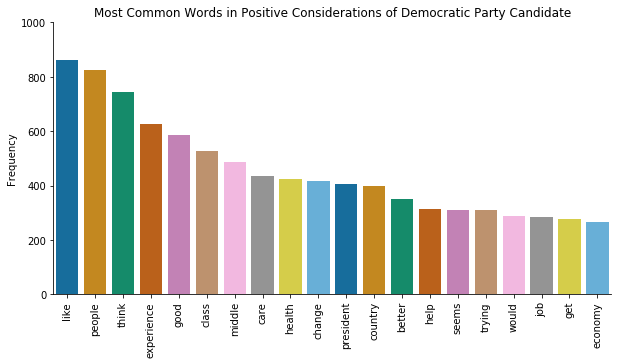

In [65]:
plt.figure(figsize = (10,5))

sns.set_palette("bright")

sns.barplot(x = 'word', y = 'frequency', data = dclikesfreq[:20],
           palette = 'colorblind')
plt.title('Most Common Words in Positive Considerations of Democratic Party Candidate')
plt.xlabel('')
plt.ylim(0,1000)
plt.xticks(rotation = 90)
plt.ylabel("Frequency")
sns.despine()
plt.show()

In [66]:
# Negative evaluations of Democratic Candidate

vec = CountVectorizer(ngram_range=(1, 1), analyzer = 'word', stop_words = stop).fit(anes_nlp['dcdlikes']) 
bag_of_words = vec.transform(anes_nlp['dcdlikes']) 
sum_words = bag_of_words.sum(axis=0) 
words_freq_dcdlikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_dcdlikes = sorted(words_freq_dcdlikes, key = lambda x: x[1], reverse=True)
dcdlikesfreq = pd.DataFrame(words_freq_dcdlikes, columns = ['word', 'frequency'])

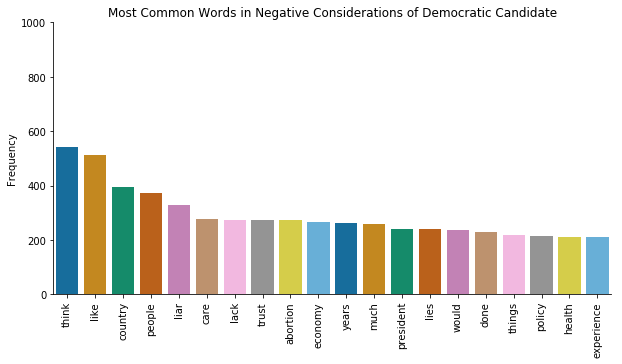

In [67]:
plt.figure(figsize = (10,5))

sns.barplot(x = 'word', y = 'frequency', data = dcdlikesfreq[:20],
           palette = 'colorblind')
plt.title('Most Common Words in Negative Considerations of Democratic Candidate')
plt.xlabel('')
plt.ylabel('Frequency')
plt.ylim(0, 1000)
plt.xticks(rotation = 90)
sns.despine()
plt.show()

The unigrams are not terribly informative in getting a sense for the positive or negative considerations that people had about Obama and Clinton. The three most common words used to describe Democrats (Barack Obama and Hillary Clinton) in positive considerations were "like," "people," and "think." But, we also see terms reflecting themes from the 2008, 2012, and 2016 campaigns: experience, health, care, change, job, economy. Clinton touted her experience and discussed health care. Obama also discussed health care and presented himself as a change candidate in 2008. The economy was a major focus of both 2008 and 2012. Most of the rest of the words are either generic or seem like they might be part of longer phrases (middle, class, country, and help). 

The three most common negative terms are also uninformative: think, like, and country. The longer list does show themes from the three campaigns campaigns. We see "economy," "abortion," "trust," and "lies." Abortion is a common critique of Democratic Party candidates, but the economy was a major theme in all three years. "Trust" and "lies" were common attacks against Clinton in 2016, but trust was also a critique of Obama in 2012 among people who did not think that he had fulfilled his policy promises. 

In [68]:
# Positive Evaluations of Republican Candidates

vec = CountVectorizer(ngram_range=(1, 1), analyzer = 'word', stop_words = stop).fit(anes_nlp['rclikes']) 
bag_of_words = vec.transform(anes_nlp['rclikes']) 
sum_words = bag_of_words.sum(axis=0) 
words_freq_rclikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_rclikes = sorted(words_freq_rclikes, key = lambda x: x[1], reverse=True)
rclikesfreq = pd.DataFrame(words_freq_rclikes, columns = ['word', 'frequency'])

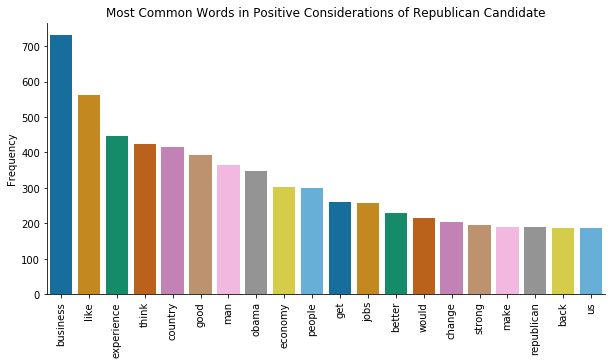

In [69]:
plt.figure(figsize = (10,5))

sns.barplot(x = 'word', y = 'frequency', data = rclikesfreq[:20],
           palette = 'colorblind')
plt.title('Most Common Words in Positive Considerations of Republican Candidate')
plt.xlabel('')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
sns.despine()
plt.show()

In [70]:
# Negative evaluations of Republican Candidate

vec = CountVectorizer(ngram_range=(1, 1), analyzer = 'word', stop_words = stop).fit(anes_nlp['rcdlikes']) 
bag_of_words = vec.transform(anes_nlp['rcdlikes']) 
sum_words = bag_of_words.sum(axis=0) 
words_freq_rcdlikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_rcdlikes = sorted(words_freq_rcdlikes, key = lambda x: x[1], reverse=True)
rcdlikesfreq = pd.DataFrame(words_freq_rcdlikes, columns = ['word', 'frequency'])

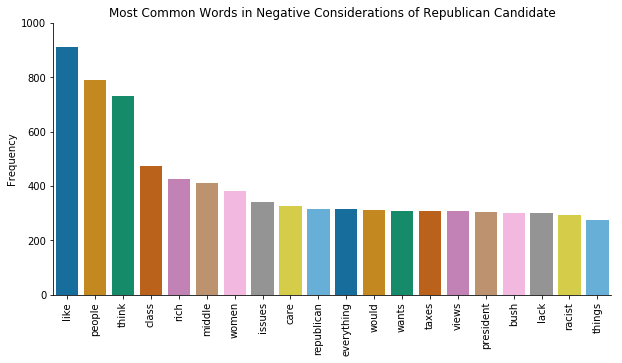

In [71]:
plt.figure(figsize = (10,5))

sns.barplot(x = 'word', y = 'frequency', data = rcdlikesfreq[:20],
           palette = 'colorblind')
plt.title('Most Common Words in Negative Considerations of Republican Candidate')
plt.xlabel('')
plt.ylabel('Frequency')
plt.ylim(0, 1000)
plt.xticks(rotation = 90)
sns.despine()
plt.show()

Positive unigrams about the Republican candidate are also rather generic, but the most common term is "business," a common theme in Republican campaigns. Other terms are themes that both parties emphasize: "economy," "jobs," and "change." Negative unigrams reflect common critiques of Republican candidates, though the three most common are rather uninformative. "Rich" and "taxes" are common criques of Republicans among Democrats. We also see "women" and "racist," which may reflect criticisms of Donald Trump in 2016. 

Do bigrams reveal more interesting general patterns?

##### Bigrams

In [72]:
# Creating the word vectors, Using nltk's stop words dictionary instead of Scikit-Learn's
vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp['dclikes']) 

# Transforming each vector
bag_of_words = vec.transform(anes_nlp['dclikes']) 

# Summing the words across respondents
sum_words = bag_of_words.sum(axis=0) 

# Calculating the frequencies and sorting them
words_freq_dclikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_dclikes = sorted(words_freq_dclikes, key = lambda x: x[1], reverse=True) 

#Putting them into a Pandas dataframe

dclikesfreq = pd.DataFrame(words_freq_dclikes, columns = ['word', 'frequency'])

In [73]:
vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp['dcdlikes']) 
bag_of_words = vec.transform(anes_nlp['dcdlikes']) 
sum_words = bag_of_words.sum(axis=0) 
words_freq_dcdlikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_dcdlikes = sorted(words_freq_dcdlikes, key = lambda x: x[1], reverse=True)
dcdlikesfreq = pd.DataFrame(words_freq_dcdlikes, columns = ['word', 'frequency'])

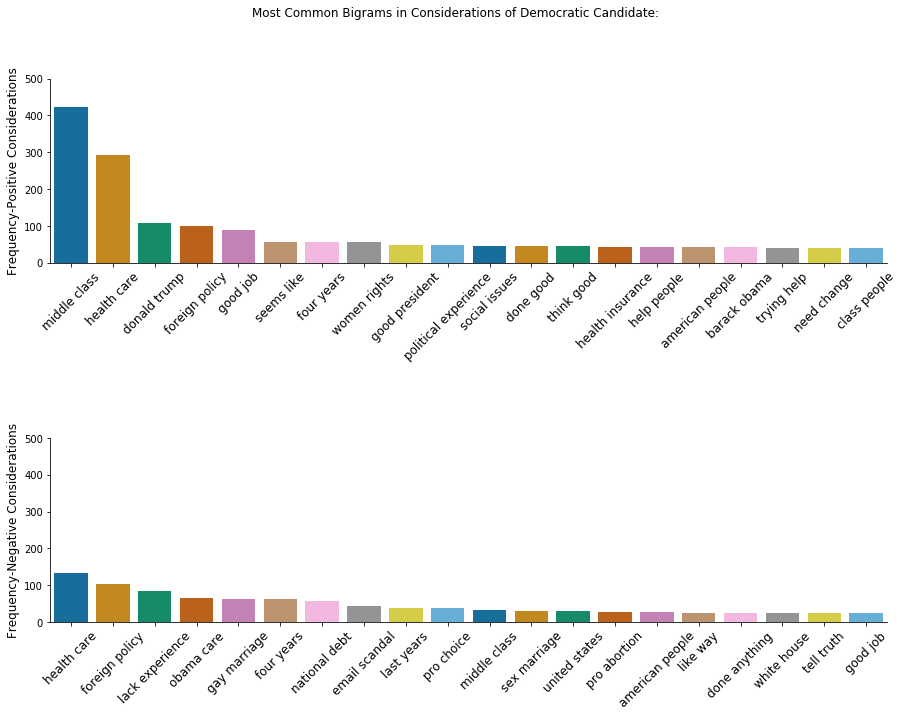

In [74]:
plt.figure(figsize = (15,10))

plt.suptitle('Most Common Bigrams in Considerations of Democratic Candidate:', fontsize = 12)

plt.subplots_adjust(hspace = .95)

sns.set_palette("bright")

plt.subplot(2, 1, 1)
sns.barplot(x = 'word', y = 'frequency', data = dclikesfreq[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylim(0, 500)
plt.xticks(rotation = 45, fontsize = 12)
plt.ylabel("Frequency-Positive Considerations", fontsize = 12)
sns.despine()

plt.subplot(2, 1, 2)

sns.barplot(x = 'word', y = 'frequency', data = dcdlikesfreq[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylabel('Frequency-Negative Considerations', fontsize = 12)
plt.ylim(0, 500)
plt.xticks(rotation = 45, fontsize = 12)
sns.despine()


plt.show()

Using bigrams provides better results than unigrams. Positive and negative considerations about the Democratic candidate are partial proof. The most popular terms in positive assessments of Democrats were: "middle class," "health care," "donald trump," "foreign policy," "womens rights," "political experience," "health insurance," "need change," and "mitt romney." The most popular terms in negative assessments were: "health care," "foreign policy," "lack experience," "obama care," "gay marriage," "national debt," "email scandal," "pro choice," "sex marriage" (likely referring to same sex marriage), and "middle class," among others. 

In [75]:
# Positive bigrams of Republican candidates

vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp['rclikes']) 
bag_of_words = vec.transform(anes_nlp['rclikes']) 
sum_words = bag_of_words.sum(axis=0) 
words_freq_rclikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_rclikes = sorted(words_freq_rclikes, key = lambda x: x[1], reverse=True)
rclikesfreq = pd.DataFrame(words_freq_rclikes, columns = ['word', 'frequency'])

In [76]:
# Negative evaluations of Republican Candidate

vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp['rcdlikes']) 
bag_of_words = vec.transform(anes_nlp['rcdlikes']) 
sum_words = bag_of_words.sum(axis=0) 
words_freq_rcdlikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_rcdlikes = sorted(words_freq_rcdlikes, key = lambda x: x[1], reverse=True)
rcdlikesfreq = pd.DataFrame(words_freq_rcdlikes, columns = ['word', 'frequency'])

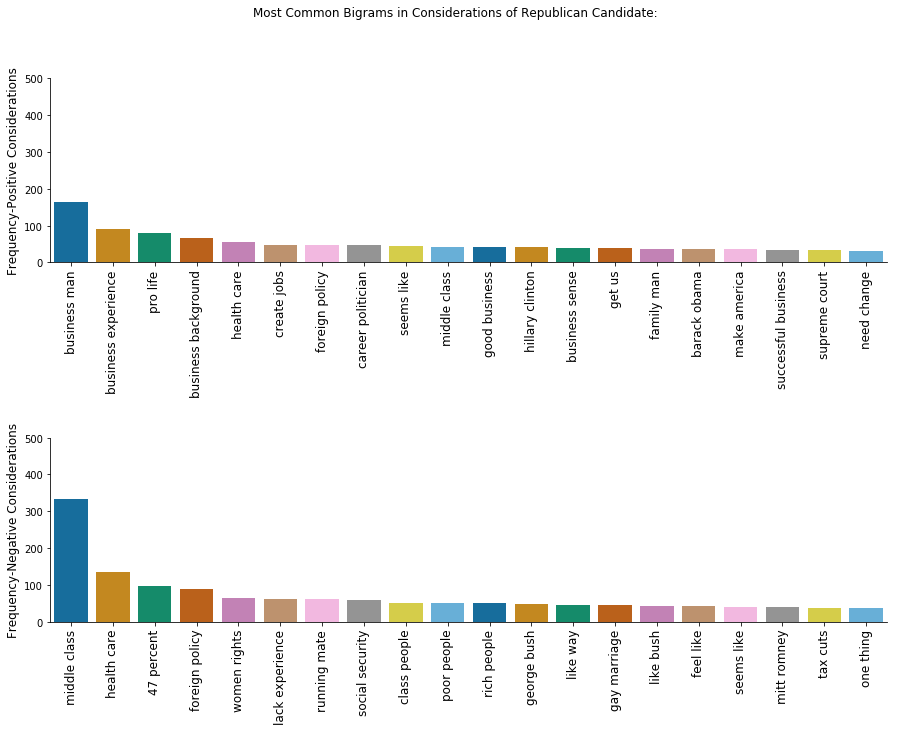

In [77]:
plt.figure(figsize = (15,10))

plt.suptitle('Most Common Bigrams in Considerations of Republican Candidate:', fontsize = 12)

plt.subplots_adjust(hspace = .95)

sns.set_palette("bright")

plt.subplot(2, 1, 1)
sns.barplot(x = 'word', y = 'frequency', data = rclikesfreq[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylim(0, 500)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("Frequency-Positive Considerations", fontsize = 12)
sns.despine()

plt.subplot(2, 1, 2)

sns.barplot(x = 'word', y = 'frequency', data = rcdlikesfreq[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylabel('Frequency-Negative Considerations', fontsize = 12)
plt.ylim(0, 500)
plt.xticks(rotation = 90, fontsize = 12)
sns.despine()
plt.show()

plt.show()

The most popular positive term is "businesss man," followed by "business experience," "pro life," "business background," among others. Popular negative terms were "middle class," "health care," "47 percent" (referring to Mitt Romney in 2012), and "womens rights," among others. 

##### 2016: Clinton vs. Trump

Let's look at bigrams about Clinton and Trump from the 2016 election. 

In [78]:
# Positive bigrams of Hillary Clinton

# Creating the word vectors, Using nltk's stop words dictionary instead of Scikit-Learn's
vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp[anes_nlp['year'] == 2016]['dclikes']) 

# Transforming each vector
bag_of_words = vec.transform(anes_nlp[anes_nlp['year'] == 2016]['dclikes']) 

# Summing the words across respondents
sum_words = bag_of_words.sum(axis=0) 

# Calculating the frequencies and sorting them
words_freq_dclikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_dclikes = sorted(words_freq_dclikes, key = lambda x: x[1], reverse=True) 

#Putting them into a Pandas dataframe

dclikesfreq = pd.DataFrame(words_freq_dclikes, columns = ['word', 'frequency'])

# Negative bigrams of Hillary Clinton
vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp[anes_nlp['year'] == 2016]['dcdlikes']) 
bag_of_words = vec.transform(anes_nlp[anes_nlp['year'] == 2016]['dcdlikes']) 
sum_words = bag_of_words.sum(axis=0) 
words_freq_dcdlikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_dcdlikes = sorted(words_freq_dcdlikes, key = lambda x: x[1], reverse=True)
dcdlikesfreq = pd.DataFrame(words_freq_dcdlikes, columns = ['word', 'frequency'])

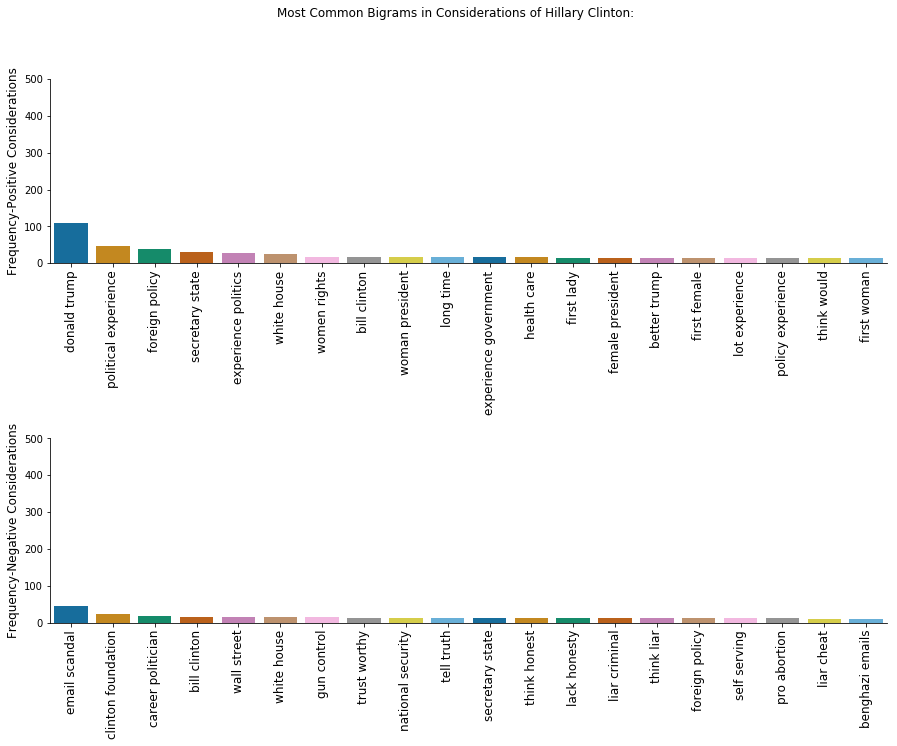

In [79]:
plt.figure(figsize = (15,10))

plt.suptitle('Most Common Bigrams in Considerations of Hillary Clinton:', fontsize = 12)

plt.subplots_adjust(hspace = .95)

sns.set_palette("bright")

plt.subplot(2, 1, 1)
sns.barplot(x = 'word', y = 'frequency', data = dclikesfreq[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylim(0, 500)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("Frequency-Positive Considerations", fontsize = 12)
sns.despine()

plt.subplot(2, 1, 2)

sns.barplot(x = 'word', y = 'frequency', data = dcdlikesfreq[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylabel('Frequency-Negative Considerations', fontsize = 12)
plt.ylim(0, 500)
plt.xticks(rotation = 90, fontsize = 12)
sns.despine()
plt.show()

plt.show()

The most common bigram in positive assessments of Clinton is "Donald Trump", followed by "political experience" and "foreign policy". Of the negative assessments of her, "email scandal" and "trust her" were the two most popular terms, followed by "clinton foundation." These terms were popular parts of the 2016 narratives. 

In [80]:
# Positive bigrams of Donald Trump

vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp[anes_nlp['year'] == 2016]['rclikes']) 
bag_of_words = vec.transform(anes_nlp[anes_nlp['year'] == 2016]['rclikes']) 
sum_words = bag_of_words.sum(axis=0) 
words_freq_rclikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_rclikes = sorted(words_freq_rclikes, key = lambda x: x[1], reverse=True)
rclikesfreq = pd.DataFrame(words_freq_rclikes, columns = ['word', 'frequency'])

# Negative evaluations of Donald Trump

vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp[anes_nlp['year'] == 2016]['rcdlikes']) 
bag_of_words = vec.transform(anes_nlp[anes_nlp['year'] == 2016]['rcdlikes']) 
sum_words = bag_of_words.sum(axis=0) 
words_freq_rcdlikes = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_rcdlikes = sorted(words_freq_rcdlikes, key = lambda x: x[1], reverse=True)
rcdlikesfreq = pd.DataFrame(words_freq_rcdlikes, columns = ['word', 'frequency'])

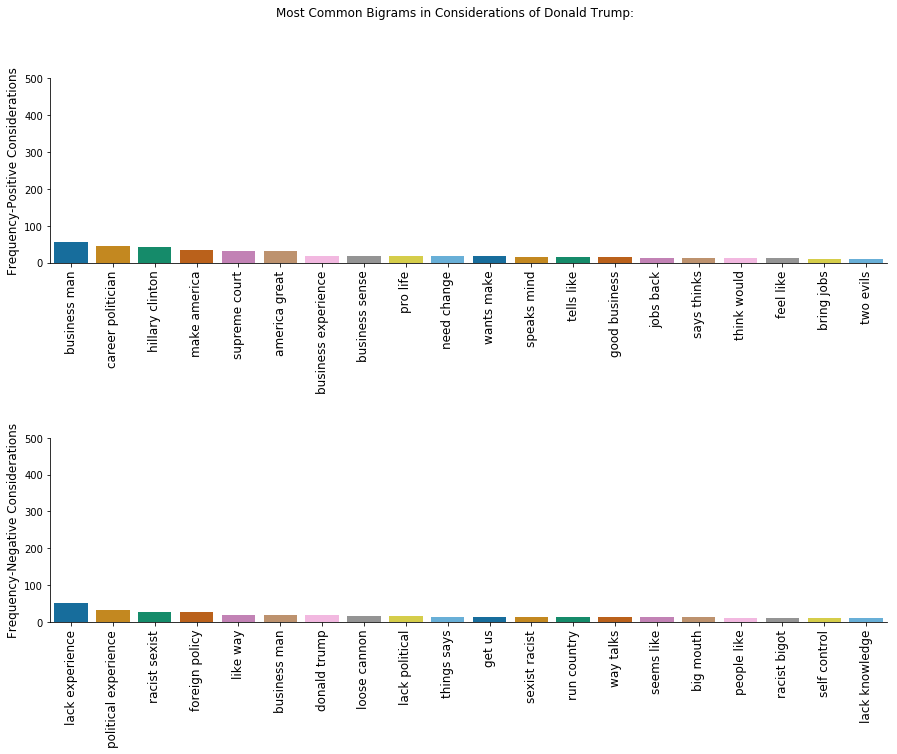

In [81]:
plt.figure(figsize = (15,10))

plt.suptitle('Most Common Bigrams in Considerations of Donald Trump:', fontsize = 12)

plt.subplots_adjust(hspace = .95)

sns.set_palette("bright")

plt.subplot(2, 1, 1)
sns.barplot(x = 'word', y = 'frequency', data = rclikesfreq[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylim(0, 500)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("Frequency-Positive Considerations", fontsize = 12)
sns.despine()

plt.subplot(2, 1, 2)

sns.barplot(x = 'word', y = 'frequency', data = rcdlikesfreq[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylabel('Frequency-Negative Considerations', fontsize = 12)
plt.ylim(0, 500)
plt.xticks(rotation = 90, fontsize = 12)
sns.despine()
plt.show()

plt.show()

Donald Trump's assessments also mirror campaign narratives fairly well. The three most common terms in the public's reasons for supporting him were "business man", "career politician", and "Hillary Clinton," which were major parts of Trump's message. He touted his business skills and how he would bring them to bear on managing government. He also touted his lack of political experience to show that he was not a career politician and could bring a fresh perspective.

In reasons for opposing him, the most popular bigram is "lack experience." Many of the critiques of his candidacy noted this as a problem. Clinton also pointed to his lack of foreign policy knowledge and experience. 

##### Barack Obama in 2008 vs 2012

In [82]:
# Positive bigrams of Barack Obama in 2008 vs. 2012

# 2008
# Creating the word vectors, Using nltk's stop words dictionary instead of Scikit-Learn's
vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp[anes_nlp['year'] == 2008]['dclikes']) 

# Transforming each vector
bag_of_words = vec.transform(anes_nlp[anes_nlp['year'] == 2008]['dclikes']) 

# Summing the words across respondents
sum_words = bag_of_words.sum(axis=0) 

# Calculating the frequencies and sorting them
words_freq_dclikes2008 = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_dclikes2008 = sorted(words_freq_dclikes2008, key = lambda x: x[1], reverse=True) 

#Putting them into a Pandas dataframe

dclikesfreq2008 = pd.DataFrame(words_freq_dclikes2008, columns = ['word', 'frequency'])

#2012

# Creating the word vectors, Using nltk's stop words dictionary instead of Scikit-Learn's
vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp[anes_nlp['year'] == 2012]['dclikes']) 

# Transforming each vector
bag_of_words = vec.transform(anes_nlp[anes_nlp['year'] == 2012]['dclikes']) 

# Summing the words across respondents
sum_words = bag_of_words.sum(axis=0) 

# Calculating the frequencies and sorting them
words_freq_dclikes2012 = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_dclikes2012 = sorted(words_freq_dclikes2012, key = lambda x: x[1], reverse=True) 

#Putting them into a Pandas dataframe

dclikesfreq2012 = pd.DataFrame(words_freq_dclikes2012, columns = ['word', 'frequency'])

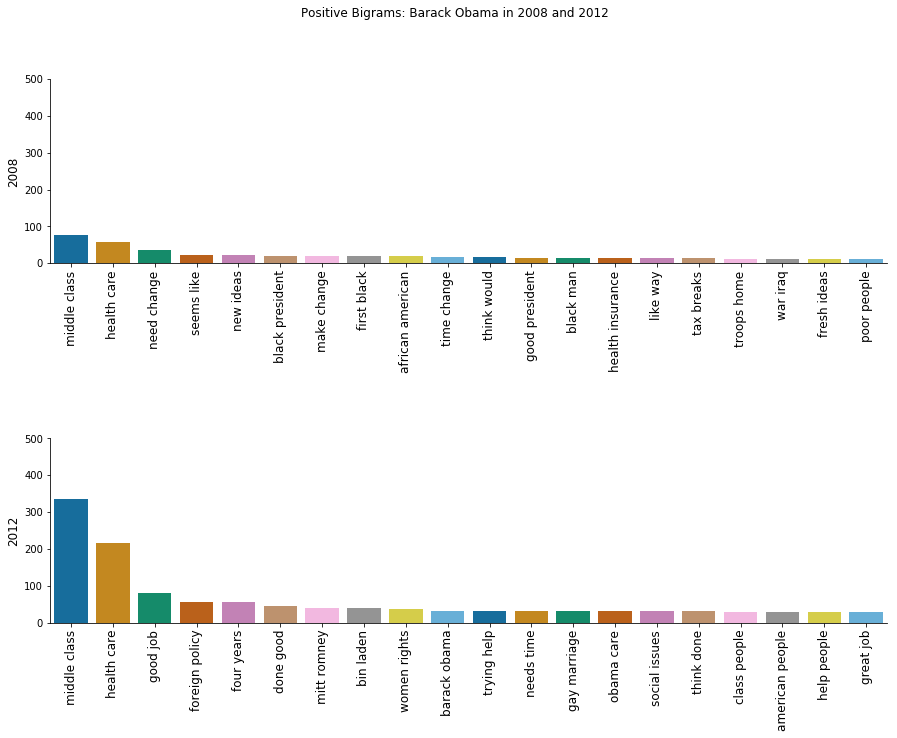

In [83]:
plt.figure(figsize = (15,10))

plt.suptitle('Positive Bigrams: Barack Obama in 2008 and 2012', fontsize = 12)

plt.subplots_adjust(hspace = .95)

sns.set_palette("bright")

plt.subplot(2, 1, 1)
sns.barplot(x = 'word', y = 'frequency', data = dclikesfreq2008[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylim(0, 500)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("2008", fontsize = 12)
sns.despine()

plt.subplot(2, 1, 2)

sns.barplot(x = 'word', y = 'frequency', data = dclikesfreq2012[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylabel('2012', fontsize = 12)
plt.ylim(0, 500)
plt.xticks(rotation = 90, fontsize = 12)
sns.despine()
plt.show()

plt.show()

Another advantage of using all three years of data is the ability to observe how people's assessments Barack Obama changed over time. [Psychologists](https://psycnet.apa.org/record/1995-17405-001) have observed that when we do not know other people very well, we tend to credit or blame their character when judging their actions. But, as we get to know them over time, we tend to judge their actions based on their motivations and the constraints of the situations that they were in. The corollary to politics is that we tend to judge candidates by their character in the beginning and by their policies and performance in office when they run for reelection. 

Changes in the content of Barack Obama's positive evaluations support that hypothesis. In 2008, a relative unknown on the national state, voters cited Obama's personal attributes more than his issue stances (referencing his race). In 2012, as an incumbent running for reelection, voters referenced his policies. We see "middle class," "health care," "good job," "foreign policy," "bin laden," among others.

In [84]:
# Negative bigrams of Barack Obama in 2008 vs. 2012

# 2008
# Creating the word vectors, Using nltk's stop words dictionary instead of Scikit-Learn's
vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp[anes_nlp['year'] == 2008]['dcdlikes']) 

# Transforming each vector
bag_of_words = vec.transform(anes_nlp[anes_nlp['year'] == 2008]['dcdlikes']) 

# Summing the words across respondents
sum_words = bag_of_words.sum(axis=0) 

# Calculating the frequencies and sorting them
words_freq_dcdlikes2008 = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_dcdlikes2008 = sorted(words_freq_dcdlikes2008, key = lambda x: x[1], reverse=True) 

#Putting them into a Pandas dataframe

dcdlikesfreq2008 = pd.DataFrame(words_freq_dcdlikes2008, columns = ['word', 'frequency'])

#2012

# Creating the word vectors, Using nltk's stop words dictionary instead of Scikit-Learn's
vec = CountVectorizer(ngram_range=(2, 2), analyzer = 'word', stop_words = stop).fit(anes_nlp[anes_nlp['year'] == 2012]['dcdlikes']) 

# Transforming each vector
bag_of_words = vec.transform(anes_nlp[anes_nlp['year'] == 2012]['dcdlikes']) 

# Summing the words across respondents
sum_words = bag_of_words.sum(axis=0) 

# Calculating the frequencies and sorting them
words_freq_dcdlikes2012 = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq_dcdlikes2012 = sorted(words_freq_dcdlikes2012, key = lambda x: x[1], reverse=True) 

#Putting them into a Pandas dataframe

dcdlikesfreq2012 = pd.DataFrame(words_freq_dcdlikes2012, columns = ['word', 'frequency'])

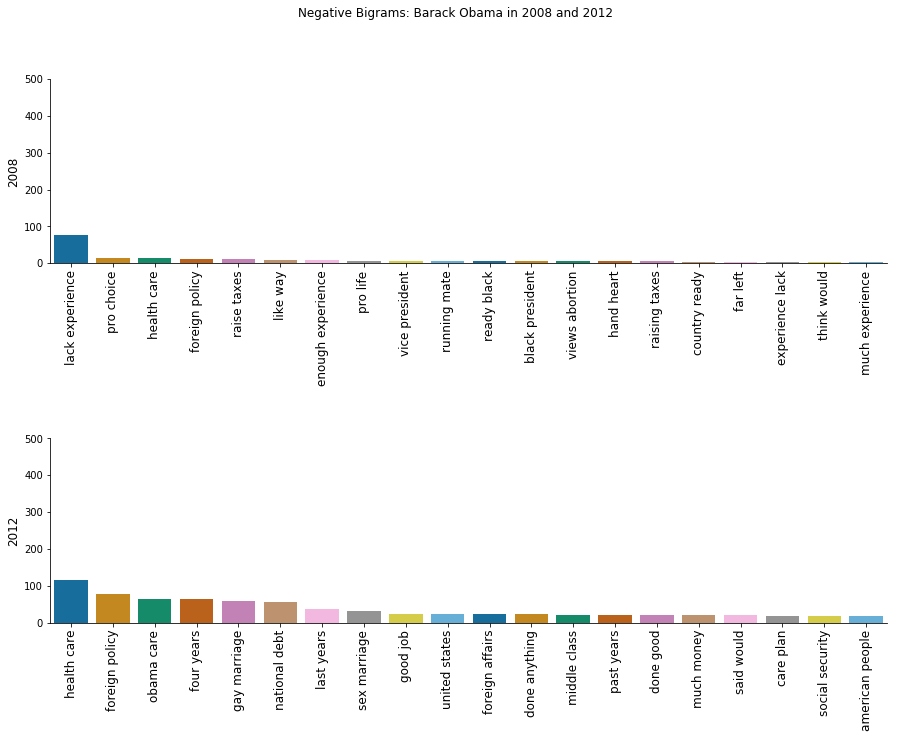

In [85]:
plt.figure(figsize = (15,10))

plt.suptitle('Negative Bigrams: Barack Obama in 2008 and 2012', fontsize = 12)

plt.subplots_adjust(hspace = .95)

sns.set_palette("bright")

plt.subplot(2, 1, 1)
sns.barplot(x = 'word', y = 'frequency', data = dcdlikesfreq2008[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylim(0, 500)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("2008", fontsize = 12)
sns.despine()

plt.subplot(2, 1, 2)

sns.barplot(x = 'word', y = 'frequency', data = dcdlikesfreq2012[:20],
           palette = 'colorblind')
plt.xlabel('')
plt.ylabel('2012', fontsize = 12)
plt.ylim(0, 500)
plt.xticks(rotation = 90, fontsize = 12)
sns.despine()
plt.show()

plt.show()

In negative evaluations of Obama in both 2008 and 2012, most of the popular terms here were policy-based, which is interesting. Changes in the content reflect what people learned about him over four years. Negative assessments in 2012 focused on aspects of Obama's record. The most frequently used terms were about health care, foreign policy, the Affordable Care Act, same sex marriage, the national debt, among others. 

#### Sentiment Analysis

In this section, we will build several models to predict whether someone's evaluation of the candidate is positive or negative, using a number of supervised learning algorithms. Since peoples' positive (or negative) evaluations of a candidate can be as short as one word (some respondents replied with "everything" in response to each of the questions), I will use a whole response to a question instead of sentences (or sentence fragments). I will combine all of the positive and negative responses about *both* candidates in order to build as large of a vocabulary as possible. 

My sentiment analysis will include employ types of models: Bag of Words and TF-IDF. I will compare the each model's performance on four algorithms using their default settings for the hyperparmeters: Naive Bayes, Random Forest (RFC), and Multilayered Perceptron Classifier (MLP). I will rely solely on the text in this process, but once it becomes clear that a certain model and algorithm pair is optimal, I will add three features from the survey to see if they improve our predictions: party affiliation, age, education, and gender. These are four features that regularly have significant effects in attitudinal models in public opinion research about candidates. At this point I will also use a Bayesian package (Hyperopt) to tune the hyperparameters to see if it we can improve the model's performance. In preliminary analysis, it took between 10-15 minutes to run some algorithms one time. Thus, I opted to use default settings for algorithms until we find the best performing model-algorithm pair. 

If we can build a useful model predicting the sentiment of an evaluation, we can apply it to similar formats like election focus groups, open-ended surveys of congressional, state, or local elections, or the next edition of this survey, which will be available in 2021. 

In [86]:
anes_nlp.head()

,rid,year,age,pid,education,gender,interest,mode,dclikes,dcdlikes,...,dclikes_sents,dcdlikes_sents,rclikes_sents,rcdlikes_sents,numdclikes,numdcdlikes,numrclikes,numrcdlikes,total_considerations,age_group
0,20081,2008,34,2.0,5.0,1.0,3.0,1,,"higher taxes, his possible picks for supreme c...",...,[],"[(higher, taxes, ,, his, possible, picks, for,...","[(tough, on, the, war, on, terror)]","[(his, immigration, policies)]",0,1,1,1,3,2.0
1,20082,2008,58,1.0,4.0,2.0,1.0,1,,refused to answer,...,[],"[(refused, to, answer)]","[(nothing, in, peticular, ,, r, just, knows, t...",[],0,1,1,0,2,5.0
2,20083,2008,39,2.0,7.0,2.0,0.0,1,his family,fear of liberal values,...,"[(his, family)]","[(fear, of, liberal, values)]","[(general, republican, values, ,, anti, aborti...","[(typical, politician, ,, says, one, thing, do...",1,1,1,1,4,3.0
3,20084,2008,49,3.0,4.0,1.0,1.0,1,,"his inexperience, and his views on taxes",...,[],"[(his, inexperience, ,, and, his, views, on, t...","[(his, views, more, or, less, on, politics, ,,...","[(he, feels, he, is, for, sending, military, o...",0,1,1,1,3,4.0
4,20085,2008,72,2.0,7.0,1.0,3.0,1,,some of his back ground and loyalties - r has ...,...,[],"[(some, of, his, back, ground, and, loyalties,...","[(same, reason, r, would, vote, agains, obama)...","[(his, age)]",0,1,2,1,4,6.0


In [87]:
# Isolating hillary and trump positive and negative text columns, with other features

dem_likes = anes_nlp[['rid', 'year', 'pid', 'education', 'gender', 'age', 
                            'dclikes']]

dem_dislikes = anes_nlp[['rid', 'year', 'pid', 'education', 'gender', 'age', 
                            'dcdlikes']]

gop_likes = anes_nlp[['rid', 'year', 'pid', 'education', 'gender', 'age', 
                            'rclikes']]

gop_dislikes = anes_nlp[['rid', 'year', 'pid', 'education', 'gender', 'age', 
                            'rcdlikes']]

In [88]:
# Creating label columns

dem_likes['sentiment'] = 'positive'
dem_dislikes['sentiment'] = 'negative'

gop_likes['sentiment'] = 'positive'
gop_dislikes['sentiment'] = 'negative'

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [89]:
# Change likes and dislikes columns names to one to merge into larger dataframe for
# NLP

dem_likes.rename(columns = {'dclikes': 'comments'}, inplace = True)
dem_dislikes.rename(columns = {'dcdlikes': 'comments'}, inplace = True)
gop_likes.rename(columns = {'rclikes': 'comments'}, inplace = True)
gop_dislikes.rename(columns = {'rcdlikes': 'comments'}, inplace = True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [90]:
# Concatenating the data.

anes_sentiment = pd.concat([dem_likes, dem_dislikes, gop_likes, gop_dislikes], ignore_index = True)

In [91]:
anes_sentiment.head(20)

,rid,year,pid,education,gender,age,comments,sentiment
0,20081,2008,2.0,5.0,1.0,34,,positive
1,20082,2008,1.0,4.0,2.0,58,,positive
2,20083,2008,2.0,7.0,2.0,39,his family,positive
3,20084,2008,3.0,4.0,1.0,49,,positive
4,20085,2008,2.0,7.0,1.0,72,,positive
5,20086,2008,2.0,6.0,2.0,71,,positive
6,20087,2008,2.0,7.0,2.0,66,,positive
7,20088,2008,2.0,6.0,1.0,56,,positive
8,20089,2008,2.0,6.0,2.0,40,,positive
9,200810,2008,1.0,7.0,1.0,55,r feels he will provide a diferent direction f...,positive


In [92]:
# Replacing empty strings in comments to NaN

anes_sentiment['comments'] = anes_sentiment['comments'].replace('', np.nan)

In [93]:
anes_sentiment.isnull().sum()/anes_sentiment.isnull().count()

rid          0.000000
year         0.000000
pid          0.000000
education    0.000320
gender       0.000000
age          0.000000
comments     0.330881
sentiment    0.000000
dtype: float64

In [94]:
anes_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50024 entries, 0 to 50023
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rid        50024 non-null  object 
 1   year       50024 non-null  int64  
 2   pid        50024 non-null  float64
 3   education  50008 non-null  float64
 4   gender     50024 non-null  float64
 5   age        50024 non-null  int64  
 6   comments   33472 non-null  object 
 7   sentiment  50024 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 3.1+ MB


In [95]:
# Dropping missing data

anes_sentiment = anes_sentiment.dropna()

In [96]:
anes_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33468 entries, 2 to 50022
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rid        33468 non-null  object 
 1   year       33468 non-null  int64  
 2   pid        33468 non-null  float64
 3   education  33468 non-null  float64
 4   gender     33468 non-null  float64
 5   age        33468 non-null  int64  
 6   comments   33468 non-null  object 
 7   sentiment  33468 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 2.3+ MB


In [97]:
anes_sentiment.sentiment.value_counts()

negative    17598
positive    15870
Name: sentiment, dtype: int64

In [98]:
17598/33468*100

52.58157045536035

####  Balanced Classifier

Our sentiment classifier is fairly well balanced. 53% of evaluations are negative and 47% are positive. 

We should convert pid, education, and gender to dummies for the algorithms, but we should also change the "age" column name to ensure that it does not overlap with a Bag of Words feature with the same name. Age is one of the words in the comments. 

In [99]:
anes_sentiment = pd.concat([anes_sentiment, pd.get_dummies(anes_sentiment['pid'], prefix = 'pid', drop_first = True)], axis=1)
anes_sentiment = pd.concat([anes_sentiment, pd.get_dummies(anes_sentiment['education'], prefix = 'education', drop_first = True)], axis=1)
anes_sentiment = pd.concat([anes_sentiment, pd.get_dummies(anes_sentiment['gender'], prefix = 'gender', drop_first = True)], axis=1)

In [100]:
anes_sentiment.rename(columns = {'age': 'years_old'},
               inplace = True)

In [101]:
anes_sentiment.columns

Index(['rid', 'year', 'pid', 'education', 'gender', 'years_old', 'comments',
       'sentiment', 'pid_2.0', 'pid_3.0', 'pid_4.0', 'education_-8.0',
       'education_1.0', 'education_2.0', 'education_3.0', 'education_4.0',
       'education_5.0', 'education_6.0', 'education_7.0', 'gender_-1.0',
       'gender_1.0', 'gender_2.0', 'gender_3.0'],
      dtype='object')

In [102]:
# Creating a numeric target variable for sentiment. 

anes_sentiment.loc[anes_sentiment['sentiment'] == 'positive', 'sentiment_numeric'] = 1
anes_sentiment.loc[anes_sentiment['sentiment'] == 'negative', 'sentiment_numeric'] = 0

##### Bag of Words: Unigrams

In [103]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', stop_words = stop, max_features = 3000) 
X = vectorizer.fit_transform(anes_sentiment['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes_sentiment.index) 
anes_bow = bow_df.merge(anes_sentiment[['sentiment_numeric']], 
                        left_index = True, right_index = True, how = 'right')

In [104]:
anes_bow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33468 entries, 2 to 50022
Columns: 3001 entries, 000 to sentiment_numeric
dtypes: float64(1), int64(3000)
memory usage: 767.8 MB


In [105]:
# Splitting dataframe into training and testing sets

Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

I am going to use accuracy to evaluate the sentiment analysis models because I want to know the proportion of cases that the model predicts correctly. We live in a fairly partisan society where the opposing major parties are roughly of equal size over time (it varies slightly from year to year and also varies with the party occupying the White House). The labels are also fairly well balanced, with 53% negative remarks and 47% positive. Thus, accuracy is a methodologically reasonable metric to use in this case.

In [106]:
# Let's store training and testing scores in lists that we can 
# use to create simple tables comparing them
unigram_training = []


In [107]:
bnb = BernoulliNB()
bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('Naive Bayes Mean Accuracy Score Is: {}%'.format(round(bnb_scores.mean()*100, 1)))

# Append training score to list
unigram_training.append(bnb_scores.mean())

[0.71883712 0.72350598 0.71354582 0.71752988 0.72111554 0.72270916
 0.70956175 0.71155378 0.73665339 0.70756972]
Naive Bayes Mean Accuracy Score Is: 71.8%


In [108]:
# Creating a testing score list 

unigram_testing = []

In [109]:
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('Bernoulli Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))

# Append testing score to list
unigram_testing.append(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))

Bernoulli Naive Bayes Accuracy Score on Test Set: 71.7%


In [110]:
bnb_confusion = pd.crosstab(y_test, y_pred, margins = True)

In [111]:
# Random Forest

rfc = RandomForestClassifier()

In [112]:
rfc_scores = cross_val_score(rfc, X_train, y_train, cv=10)
print(rfc_scores)
print('Random Forest, Mean score is: {}%'.format(round(rfc_scores.mean()*100, 1)))
unigram_training.append(rfc_scores.mean())

[0.70211071 0.70557769 0.69601594 0.69880478 0.70199203 0.71195219
 0.6876494  0.68685259 0.71553785 0.67848606]
Random Forest, Mean score is: 69.8%


In [113]:
y_pred = rfc.fit(X_train, y_train).predict(X_test)
print('Random Forest Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
unigram_testing.append(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))

Random Forest Accuracy Score on Test Set: 69.4%


In [114]:
# Establish and fit the default model.
mlp = MLPClassifier()
mlp_scores = cross_val_score(mlp, X_train, y_train, cv=10)
print(mlp_scores)
print('Multilayered Perceptron Classifier, Mean score is: {}%'.format(round(mlp_scores.mean()*100, 1)))
unigram_training.append(mlp_scores.mean())

[0.70250896 0.7059761  0.69601594 0.69243028 0.68167331 0.71115538
 0.69681275 0.69482072 0.71633466 0.69840637]
Multilayered Perceptron Classifier, Mean score is: 70.0%


In [115]:
y_pred = mlp.fit(X_train, y_train).predict(X_test)
print('MLP Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
unigram_testing.append(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))

MLP Accuracy Score on Test Set: 69.6%


###### Evaluating the Unigram Bag of Words Performances

In [116]:
algorithms = ['Naive Bayes', 'Random Forest', 'Multi-Layer Perceptron']

In [117]:
unigrams = pd.DataFrame(list(zip(algorithms, unigram_training, unigram_testing)), 
                       columns = ['Algorithm', 'Training Accuracy', 'Testing Accuracy'])

In [118]:
print('Unigram Bag of Words Performance\n')
print(unigrams)

Unigram Bag of Words Performance

                Algorithm  Training Accuracy  Testing Accuracy
0             Naive Bayes           0.718258          0.716625
1           Random Forest           0.698498          0.694036
2  Multi-Layer Perceptron           0.699613          0.696426


Naive Bayes achieved higher accuracy levels than Random Forest, Gradient Boosting Classifier, or the neural networks Multi-Layer Perceptron algorithm. Overfitting does not apear to be a problem, as there is only a 1 point difference between mean cross validation accuracy score on the training set and the testing set accuracy score. 

In [119]:
print('Naive Bayes Confusion Matrix\n')
print(bnb_confusion)

Naive Bayes Confusion Matrix

col_0               0.0   1.0   All
sentiment_numeric                  
0.0                2602  1789  4391
1.0                 582  3394  3976
All                3184  5183  8367


In [120]:
print('The false positive rate is {}%'.format(round(1789/4391*100, 1)))
print('The false negative rate is {}%'.format(round(582/3184*100, 1)))

The false positive rate is 40.7%
The false negative rate is 18.3%


The model has a false positive rate of 40.7% and a false negative rate is 18.3%. There is room for improvement. In the next section we'll try digrams on Naive Bayes and MLP because they outperformed the other algorithms and were fairly close in accuracy scores. 

##### Bag of Words: Bigrams

In [121]:
# Setting 'ngram_range' to 2 to do bigrams

vectorizer = CountVectorizer(ngram_range = (2, 2), analyzer='word', stop_words = stop, max_features = 3000) 
X = vectorizer.fit_transform(anes_sentiment['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes_sentiment.index) 
anes_bow = bow_df.merge(anes_sentiment['sentiment_numeric'], 
                        left_index = True, right_index = True, how = 'right')

In [122]:
Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [123]:
bitrigram_training = []

In [124]:
bnb = BernoulliNB()
bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))
bitrigram_training.append(round(bnb_scores.mean()*100, 1))

[0.63878933 0.62749004 0.6187251  0.63027888 0.61115538 0.63625498
 0.63705179 0.64143426 0.62191235 0.6247012 ]
Naive Bayes Mean score is: 62.9%


In [125]:
bitrigram_testing = []

In [126]:
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
bitrigram_testing.append(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))

Naive Bayes Accuracy Score on Test Set: 63.8%


In [127]:
pd.crosstab(y_pred, y_test, margins = True)

sentiment_numeric,0.0,1.0,All
row_0,,,
0.0,3895,2534,6429
1.0,496,1442,1938
All,4391,3976,8367


##### Trigrams Bag of Words

In [128]:
vectorizer = CountVectorizer(ngram_range = (3, 3), analyzer='word', stop_words = stop, max_features = 3000) 
X = vectorizer.fit_transform(anes_sentiment['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes_sentiment.index) 
anes_bow = bow_df.merge(anes_sentiment['sentiment_numeric'], 
                        left_index = True, right_index = True, how = 'right')

In [129]:
Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [130]:
bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))
bitrigram_training.append(round(bnb_scores.mean()*100, 1))

[0.57029072 0.56573705 0.56215139 0.57131474 0.54940239 0.56533865
 0.56972112 0.5625498  0.57051793 0.5561753 ]
Naive Bayes Mean score is: 56.4%


In [131]:
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('Bernoulli Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
bitrigram_testing.append(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))

Bernoulli Naive Bayes Accuracy Score on Test Set: 56.2%


In [132]:
pd.crosstab(y_pred, y_test, margins = True)

sentiment_numeric,0.0,1.0,All
row_0,,,
0.0,4158,3432,7590
1.0,233,544,777
All,4391,3976,8367


In [133]:
bitrigrams_algorithms = ['Naive Bayes Trigram', 'Naive Bayes Trigram']

In [134]:
bitrigrams_performance = pd.DataFrame(list(zip(bitrigrams_algorithms, bitrigram_training, bitrigram_testing)), 
                       columns = ['Algorithm', 'Training Accuracy', 'Testing Accuracy'])

In [135]:
print('Performance: Bigram and Trigram Bag of Words\n')
print(bitrigrams_performance)

Performance: Bigram and Trigram Bag of Words

             Algorithm  Training Accuracy  Testing Accuracy
0  Naive Bayes Trigram               62.9          0.637863
1  Naive Bayes Trigram               56.4          0.561970


In [136]:
print('Unigram Bag of Words Performance\n')
print(unigrams)

Unigram Bag of Words Performance

                Algorithm  Training Accuracy  Testing Accuracy
0             Naive Bayes           0.718258          0.716625
1           Random Forest           0.698498          0.694036
2  Multi-Layer Perceptron           0.699613          0.696426


##### Best Model and Algorithm for Bag of Words

A unigram Bag of Words with the Naive Bayes algorithm achieved a higher accuracy score than the others. We also tried a unigram BOW with Random Forest and a multilayer perceptron algorithm. Since Naive Bayes was the best performer with unigrams, we only used it with bigrams and trigrams. While the exploratory analysis showed that the word pairs were more informative than single words, they were not more successful in predicting the sentiment of peoples' remarks. 

##### TF-IDF

A Bag of Words model is usually fairly effective, especially on small datasets like the one we are using here. But, it treats all terms the same and ignores the relative important of terms in their respective documents. TF-IDF, on the other hand, weights that might appear frequently in a document (or in our case an set of considerations), but not across others higher than terms that appear frequently across many documents. It might be possible that TF-IDF might therefore scores higher accuracy levels. For consistency purposes, I will mostly rely on the tfidf vectorizer's default settings.

In [137]:
vectorizer = TfidfVectorizer(stop_words = stop, # using NLTK's stop words library 
                             analyzer = 'word',
                             ngram_range = (1, 1), # choosing unigrams
                             lowercase = True, 
                             use_idf = True,# we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', # Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True, # Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                             max_features = 3000
                            )

X = vectorizer.fit_transform(anes_sentiment['comments'])
tfidf_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names(), index = anes_sentiment.index)
anes_tfidf = tfidf_df.merge(anes_sentiment['sentiment_numeric'], 
                        left_index = True, right_index = True, how = 'right')

Y = anes_tfidf['sentiment_numeric']
X = anes_tfidf.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=11)

In [138]:
tfidf_training = []

In [139]:
bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))
tfidf_training.append(round(bnb_scores.mean()*100, 1))

[0.71127041 0.70756972 0.70199203 0.71195219 0.71792829 0.70956175
 0.71035857 0.70159363 0.68685259 0.71553785]
Naive Bayes Mean score is: 70.7%


In [140]:
tfidf_testing = []

In [141]:
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
tfidf_testing.append(round(accuracy_score(y_test, y_pred, normalize = True, sample_weight = None)*100, 1))

Naive Bayes Accuracy Score on Test Set: 71.1%


In [142]:
mlp_scores = cross_val_score(mlp, X_train, y_train, cv=10)
print(mlp_scores)
print('MLP Mean score is: {}%'.format(round(mlp_scores.mean()*100, 1)))
tfidf_training.append(round(mlp_scores.mean()*100,1))

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.67502987 0.68605578 0.69960159 0.69920319 0.68804781 0.69721116
 0.68366534 0.69561753 0.69282869 0.71553785]
MLP Mean score is: 69.3%


In [143]:
y_pred = mlp.fit(X_train, y_train).predict(X_test)
print('MLP Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
tfidf_testing.append(round(accuracy_score(y_test, y_pred, normalize = True, sample_weight = None)*100, 1))

MLP Accuracy Score on Test Set: 70.3%


In [144]:
tfidf_algorithms = ['Naive Bayes', 'Multi-layer Perceptron']

In [145]:
tfidf_performance = pd.DataFrame(list(zip(tfidf_algorithms, tfidf_training, tfidf_testing)), 
                       columns = ['Algorithm', 'Training Accuracy', 'Testing Accuracy'])

In [146]:
print('TF-IDF Performance \n')
print(tfidf_performance)

TF-IDF Performance 

                Algorithm  Training Accuracy  Testing Accuracy
0             Naive Bayes               70.7              71.1
1  Multi-layer Perceptron               69.3              70.3


TF-idf performed only slightly worse than Bag of Words. Once again, Naive Bayes outperforms MLP. It achieved a 71% score on the test set, while MLP scores 70.4%. If the dataset were much bigger, MLP would probably be the one that performed the best. 

In [147]:
y_pred = bnb.fit(X_train, y_train).predict(X_test)
bnb_confusion = pd.crosstab(y_test, y_pred, margins = True)

In [148]:
print(bnb_confusion)

col_0               0.0   1.0   All
sentiment_numeric                  
0.0                3639   729  4368
1.0                1689  2310  3999
All                5328  3039  8367


In [149]:
print('The false positive rate is {}%'.format(round(729/3039*100, 1)))
print('The false negative rate is {}%'.format(round(1689/5328*100, 1)))

The false positive rate is 24.0%
The false negative rate is 31.7%


We have a false positive rate of 24% and a false negative rate of 32%, which is a more balanced set of errors than before. But there is still a lot of room for improvement. 

In [150]:
# To save on memory, I am deleting the tf-idf dataframes and the Bag of Words dataframe

del tfidf_df
del anes_tfidf
del anes_bow

In [151]:
# deleting bow_df
del bow_df

Naive Bayes performs better than the neural networks using tf-idf and it performs slightly better than Bag of Words, as the model does better on the test set than the training set. 

##### Adding Other Features

Can we improve the the unigram BOW by adding partisanship, age, education, or gender? 

In [152]:
anes_sentiment.columns

Index(['rid', 'year', 'pid', 'education', 'gender', 'years_old', 'comments',
       'sentiment', 'pid_2.0', 'pid_3.0', 'pid_4.0', 'education_-8.0',
       'education_1.0', 'education_2.0', 'education_3.0', 'education_4.0',
       'education_5.0', 'education_6.0', 'education_7.0', 'gender_-1.0',
       'gender_1.0', 'gender_2.0', 'gender_3.0', 'sentiment_numeric'],
      dtype='object')

In [153]:
vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer='word', stop_words = stop, max_features = 3000) 
X = vectorizer.fit_transform(anes_sentiment['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes_sentiment.index) 
anes_bow = bow_df.merge(anes_sentiment[['sentiment_numeric','pid_2.0', 'pid_3.0', 'pid_4.0']], 
                        left_index = True, right_index = True, how = 'right')

In [154]:
Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [155]:
add_features = []

In [156]:
bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))
add_features.append(round(bnb_scores.mean()*100, 1))

[0.7212266  0.70677291 0.70796813 0.70956175 0.712749   0.72111554
 0.70717131 0.71354582 0.73665339 0.70717131]
Naive Bayes Mean score is: 71.4%


In [157]:
add_features_test = []

In [158]:
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
add_features_test.append(round(accuracy_score(y_test, y_pred, normalize = True, sample_weight = None)*100, 1))

Naive Bayes Accuracy Score on Test Set: 71.6%


##### Adding Age

In [159]:
vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer='word', stop_words = stop, max_features = 3000) 
X = vectorizer.fit_transform(anes_sentiment['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes_sentiment.index) 
anes_bow = bow_df.merge(anes_sentiment[['sentiment_numeric','pid_2.0', 'pid_3.0', 'pid_4.0', 'years_old']], 
                        left_index = True, right_index = True, how = 'right')

Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [160]:
# Training the Naive Bayes and Cross Validating

bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))
add_features.append(round(bnb_scores.mean()*100, 1))

[0.72003186 0.70756972 0.70796813 0.71075697 0.712749   0.72071713
 0.70796813 0.7123506  0.73705179 0.70756972]
Naive Bayes Mean score is: 71.4%


In [161]:
# Running the model on testing data

y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
add_features_test.append(round(accuracy_score(y_test, y_pred, normalize = True, sample_weight = None)*100, 1))

Naive Bayes Accuracy Score on Test Set: 71.6%


##### Adding Education

In [162]:
vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer='word', stop_words = stop, max_features = 3000) 
X = vectorizer.fit_transform(anes_sentiment['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes_sentiment.index) 
anes_bow = bow_df.merge(anes_sentiment[['sentiment_numeric','pid_2.0', 'pid_3.0', 'pid_4.0', 'years_old',
                                       'education_-8.0', 'education_1.0', 'education_2.0', 'education_3.0', 
                                        'education_4.0','education_5.0', 'education_6.0', 'education_7.0']], 
                        left_index = True, right_index = True, how = 'right')

Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [163]:
# Training the Naive Bayes and Cross Validating

bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))
add_features.append(round(bnb_scores.mean()*100, 1))

[0.72003186 0.71593625 0.70916335 0.71354582 0.7123506  0.71832669
 0.70996016 0.70717131 0.72948207 0.70079681]
Naive Bayes Mean score is: 71.4%


In [164]:
# Running the model on testing data

y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
add_features_test.append(round(accuracy_score(y_test, y_pred, normalize = True, sample_weight = None)*100, 1))

Naive Bayes Accuracy Score on Test Set: 71.3%


##### Adding Gender

In [165]:
vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer='word', stop_words = stop, max_features = 3000) 
X = vectorizer.fit_transform(anes_sentiment['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes_sentiment.index) 
anes_bow = bow_df.merge(anes_sentiment[['sentiment_numeric','pid_2.0', 'pid_3.0', 'pid_4.0', 'years_old',
                                       'education_-8.0', 'education_1.0', 'education_2.0', 'education_3.0', 
                                        'education_4.0','education_5.0', 'education_6.0', 'education_7.0',
                                       'gender_-1.0', 'gender_1.0', 'gender_2.0', 'gender_3.0']], 
                        left_index = True, right_index = True, how = 'right')

Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [166]:
# Training the Naive Bayes and Cross Validating

bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))
add_features.append(round(bnb_scores.mean()*100, 1))

[0.72481083 0.70876494 0.70916335 0.71314741 0.7123506  0.71912351
 0.70996016 0.70717131 0.72948207 0.69960159]
Naive Bayes Mean score is: 71.3%


In [167]:
# Running the model on testing data

y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
add_features_test.append(round(accuracy_score(y_test, y_pred, normalize = True, sample_weight = None)*100, 1))

Naive Bayes Accuracy Score on Test Set: 71.4%


##### Adding Survey Year

In [168]:
# Creating Dummies for Year

anes_sentiment = pd.concat([anes_sentiment, pd.get_dummies(anes_sentiment['year'], prefix = 'year', drop_first = True)], axis=1)

In [169]:
anes_sentiment.head()

,rid,year,pid,education,gender,years_old,comments,sentiment,pid_2.0,pid_3.0,...,education_5.0,education_6.0,education_7.0,gender_-1.0,gender_1.0,gender_2.0,gender_3.0,sentiment_numeric,year_2012,year_2016
2,20083,2008,2.0,7.0,2.0,39,his family,positive,1,0,...,0,0,1,0,0,1,0,1.0,0,0
9,200810,2008,1.0,7.0,1.0,55,r feels he will provide a diferent direction f...,positive,0,0,...,0,0,1,0,1,0,0,1.0,0,0
15,200816,2008,3.0,7.0,2.0,72,"i think he has a lot of new ideas, and even th...",positive,0,1,...,0,0,1,0,0,1,0,1.0,0,0
18,200819,2008,1.0,7.0,1.0,61,probably more of the social aspects of his cam...,positive,0,0,...,0,0,1,0,1,0,0,1.0,0,0
20,200821,2008,1.0,7.0,2.0,31,"change... he promises change. no, i'm mixed. ...",positive,0,0,...,0,0,1,0,0,1,0,1.0,0,0


In [170]:
vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer='word', stop_words = stop, max_features = 3000) 
X = vectorizer.fit_transform(anes_sentiment['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes_sentiment.index) 
anes_bow = bow_df.merge(anes_sentiment[['sentiment_numeric','pid_2.0', 'pid_3.0', 'pid_4.0', 'years_old',
                                       'education_-8.0', 'education_1.0', 'education_2.0', 'education_3.0', 
                                        'education_4.0','education_5.0', 'education_6.0', 'education_7.0',
                                       'gender_-1.0', 'gender_1.0', 'gender_2.0', 'gender_3.0', 'year_2012',
                                       'year_2016']], 
                        left_index = True, right_index = True, how = 'right')

Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [171]:
# Training the Naive Bayes and Cross Validating

bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))
add_features.append(round(bnb_scores.mean()*100, 1))

[0.71724413 0.71952191 0.70916335 0.72390438 0.72151394 0.71314741
 0.70916335 0.71593625 0.73346614 0.70717131]
Naive Bayes Mean score is: 71.7%


In [172]:
# Running the model on testing data

y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
add_features_test.append(round(accuracy_score(y_test, y_pred, normalize = True, sample_weight = None)*100, 1))

Naive Bayes Accuracy Score on Test Set: 71.1%


Adding other features did not help at all. Rather, we did slightly worse.

In [173]:
models = ['Party ID', 'Party ID, Age', 'Party ID, Age, Education', 'Party ID, Age, Education, Gender', 'Party ID, Age, Education, Gender, Survey Year']

In [174]:
other_features = pd.DataFrame(list(zip(models, add_features, add_features_test)), 
                       columns = ['Added Feature', 'Training Accuracy', 'Testing Accuracy'])

In [175]:
print('Performance of Bag of Words, Plus: \n')
other_features

Performance of Bag of Words, Plus: 



,Added Feature,Training Accuracy,Testing Accuracy
0,Party ID,71.4,71.6
1,"Party ID, Age",71.4,71.6
2,"Party ID, Age, Education",71.4,71.3
3,"Party ID, Age, Education, Gender",71.3,71.4
4,"Party ID, Age, Education, Gender, Survey Year",71.7,71.1


In [176]:
print('Performance of Unigram Bag of Words')
unigrams

Performance of Unigram Bag of Words


,Algorithm,Training Accuracy,Testing Accuracy
0,Naive Bayes,0.718258,0.716625
1,Random Forest,0.698498,0.694036
2,Multi-Layer Perceptron,0.699613,0.696426


##### Tuning the Model for Better Performance

We probably will not improve the model much by tuning hyperparameters in a Naive Bayes algorithm, but I will tune it with Hyperopt to see if we can improve it.

In [230]:
vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer='word', stop_words = stop, max_features = 3000) 
X = vectorizer.fit_transform(anes_sentiment['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes_sentiment.index) 
anes_bow = bow_df.merge(anes_sentiment['sentiment_numeric'], 
                        left_index = True, right_index = True, how = 'right')

Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [231]:
def hyperopt_train_test(params):
    bnb = BernoulliNB(**params)
    return cross_val_score(bnb, X_train, y_train, cv = 10).mean()

# Populating the search space with hyperparameters and values to evaluate

space = {
    'alpha': hp.uniform('alpha', 0.001, 100.0),
    'fit_prior': hp.choice('fit_prior', [False, True])
}

# Telling Hyperopt to minimize the negative of the CV accuracy score, which will 
# prompt the algorithm to maximize the function rather than minimize it.

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

# Setting random state seed and populating fmin with optimization algorithm (TPE), 
# number of trials (max_evals), and the trials list where evaluation scores are stored.

seed = 90
trials = Trials()

# 'best' will store the optimal set of hyperparameters
best = fmin(f, space, 
            # Selecting TPE as the estimator
            algo = tpe.suggest, 
            
            # Selecting 100 Trials
            max_evals = 100, 
            
            # Telling algorithm where to store trial results
            trials = trials,
            
            # Setting random state seed to reproduce results in the future
            rstate = np.random.RandomState(seed))


print('The best hyperparameters are: {}'.format(space_eval(space, best)))

100%|██████████| 100/100 [54:57<00:00, 32.98s/it, best loss: -0.7181386282825687]
The best hyperparameters are: {'alpha': 1.4257028262609563, 'fit_prior': True}


In [232]:
bnb = BernoulliNB(alpha = 1.4257028262609563, fit_prior = True)
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))

Naive Bayes Accuracy Score on Test Set: 71.8%


Unsurprisingly, we did not improve our performance by tuning hyperparameters. Let's see if lemmatizing the text does better. 

##### Lemmatizing Text

In [180]:
anes_sentiment['lemmatized'] = anes_sentiment['comments'].apply(lambda x: " ".join([w.lemma_ for w in nlp(x)]))

In [181]:
anes_sentiment[['comments', 'lemmatized']].head(20)

,comments,lemmatized
2,his family,-PRON- family
9,r feels he will provide a diferent direction f...,r feel -PRON- will provide a diferent directio...
15,"i think he has a lot of new ideas, and even th...","i think -PRON- have a lot of new idea , and ev..."
18,probably more of the social aspects of his cam...,probably more of the social aspect of -PRON- c...
20,"change... he promises change. no, i'm mixed. ...","change ... -PRON- promise change . no , -PRO..."
21,"got a lot of good, going to be good","get a lot of good , go to be good"
22,"positive,intelligent","positive , intelligent"
23,handsome and smart,handsome and smart
24,he represents the minority and has the potenti...,-PRON- represent the minority and have the pot...
25,his stand on the iraq war,-PRON- stand on the iraq war


In [182]:
vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer='word', stop_words = stop, max_features = 3000) 
X = vectorizer.fit_transform(anes_sentiment['lemmatized'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes_sentiment.index) 
anes_bow = bow_df.merge(anes_sentiment['sentiment_numeric'], 
                        left_index = True, right_index = True, how = 'right')

Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [183]:
bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))

[0.71923536 0.71394422 0.71195219 0.72270916 0.71633466 0.70717131
 0.70796813 0.71673307 0.73386454 0.70398406]
Naive Bayes Mean score is: 71.5%


Lemmatizing the text did not give us a better accuracy score on the training set. We are better off using the original form. Do we do better leaving the stop words in the text?

##### Leaving Stop Words In The Text

While stop words can seem like they do not add value to models, it is possible stop words may be important parts of phrases that capture positive or negative sentiment. In the exploratory analysis, we saw phrases like "Trust her," and "I don't trust him." We will rerun the Unigram Bag of Words with stop words included to see if we do better than we have thus far. 

In [184]:
vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer='word', stop_words = None, max_features = 3000) 
X = vectorizer.fit_transform(anes_sentiment['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes_sentiment.index) 
anes_bow = bow_df.merge(anes_sentiment['sentiment_numeric'], 
                        left_index = True, right_index = True, how = 'right')

Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [185]:
bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('Naive Bayes Mean Score is: {}%'.format(round(bnb_scores.mean()*100, 1)))

[0.72919156 0.7314741  0.72350598 0.7250996  0.72828685 0.72390438
 0.71633466 0.72031873 0.74302789 0.70796813]
Naive Bayes Mean Score is: 72.5%


In [186]:
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('Naive Bayes Accuracy Score on Test Set, With Stop Words: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))

Naive Bayes Accuracy Score on Test Set, With Stop Words: 72.2%


Leaving the stop words in the text actually helped us improve our accuracy score. This is likely because some stop words are part of important phrases to describe either or both candidates that help determine sentiment. But, we still have 34% false positive rates and 18% false negative rates. 

In [187]:
pd.crosstab(y_test, y_pred, margins = True)

col_0,0.0,1.0,All
sentiment_numeric,,,
0.0,2630,1761,4391
1.0,562,3414,3976
All,3192,5175,8367


In [188]:
print('The false positive rate is {}%'.format(round(1765/5177*100, 1)))
print('The false negative rate is {}%'.format(round(564/3190*100, 1)))

The false positive rate is 34.1%
The false negative rate is 17.7%


##### Sentiment Analysis for Individual Years

In a preliminary phase, I focused on a single year, 2016, and achieved higher accuracy scores. So, I will replicate that here and will use the same analysis for 2008 and 2012, respectively. It is possible that a better approach is to use models for individuals years instead of pooling multiple years together. 

I also found that a unigram BOW using Naive Bayes gave me the best results for 2016. So, I will use that combination for all three years individually. Stop words will be left in the text. 

In [189]:
# 2008 BOW using unigrams

anes2008 = anes_sentiment[anes_sentiment['year'] == 2008]

vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer='word', stop_words = None, max_features = 3000) 
X = vectorizer.fit_transform(anes2008['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes2008.index) 
anes_bow = bow_df.merge(anes2008['sentiment_numeric'], 
                        left_index = True, right_index = True, how = 'right')

Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [190]:
single_years_training = []

In [191]:
bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('2008 Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))
single_years_training.append(round(bnb_scores.mean()*100, 1))

[0.74715909 0.76136364 0.76704545 0.73863636 0.77556818 0.72934473
 0.76923077 0.76068376 0.77777778 0.72649573]
2008 Naive Bayes Mean score is: 75.5%


In [192]:
single_years_testing = []

In [193]:
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('2008 Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
single_years_testing.append(round(accuracy_score(y_test, y_pred, normalize = True, sample_weight = None)*100, 1))

2008 Naive Bayes Accuracy Score on Test Set: 77.6%


In [194]:
anes2012 = anes_sentiment[anes_sentiment['year'] == 2012]

vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer='word', stop_words = None, max_features = 3000) 
X = vectorizer.fit_transform(anes2012['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes2012.index) 
anes_bow = bow_df.merge(anes2012['sentiment_numeric'], 
                        left_index = True, right_index = True, how = 'right')

Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [195]:
bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('2012 Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))
single_years_training.append(round(bnb_scores.mean()*100, 1))

[0.64295486 0.66005472 0.66347469 0.65800274 0.65526676 0.66689466
 0.66187543 0.66324435 0.64887064 0.65092402]
2012 Naive Bayes Mean score is: 65.7%


In [196]:
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('2012 Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
single_years_testing.append(round(accuracy_score(y_test, y_pred, normalize = True, sample_weight = None)*100, 1))

2012 Naive Bayes Accuracy Score on Test Set: 64.8%


In [197]:
anes2016 = anes_sentiment[anes_sentiment['year'] == 2016]

vectorizer = CountVectorizer(ngram_range = (1, 1), analyzer='word', stop_words = None, max_features = 3000) 
X = vectorizer.fit_transform(anes2016['comments'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names(), index = anes2016.index) 
anes_bow = bow_df.merge(anes2016['sentiment_numeric'], 
                        left_index = True, right_index = True, how = 'right')

Y = anes_bow['sentiment_numeric']
X = anes_bow.drop(['sentiment_numeric'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=10)

In [198]:
bnb_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print(bnb_scores)
print('2016 Naive Bayes Mean score is: {}%'.format(round(bnb_scores.mean()*100, 1)))
single_years_training.append(round(bnb_scores.mean()*100, 1))

[0.84361549 0.85939742 0.83644189 0.84505022 0.83787661 0.82926829
 0.84935438 0.84935438 0.84935438 0.81609195]
2016 Naive Bayes Mean score is: 84.2%


In [199]:
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print('2016 Naive Bayes Accuracy Score on Test Set: {}%'.format((round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100, 1))))
single_years_testing.append(round(accuracy_score(y_test, y_pred, normalize = True, sample_weight = None)*100, 1))

2016 Naive Bayes Accuracy Score on Test Set: 84.0%


In [200]:
years = [2008, 2012, 2016]

In [201]:
single_year = pd.DataFrame(list(zip(years, single_years_training, single_years_testing)), 
                       columns = ['Year', 'Training Accuracy', 'Testing Accuracy'])

In [202]:
print('Unigram Bag of Words Model, Naive Bayes,\n Performance for Individual Survey Years \n Stop words Included \n')
print(single_year)

Unigram Bag of Words Model, Naive Bayes,
 Performance for Individual Survey Years 
 Stop words Included 

   Year  Training Accuracy  Testing Accuracy
0  2008               75.5              77.6
1  2012               65.7              64.8
2  2016               84.2              84.0


Looking at individual survey years does not necessarily give us better performance. Sentiment Analysis for 2008 and 2016 individually was better than pooling the years together, but 2012 was much worse. If each of the component years outperformed. analysis pooling the data, we might be able to say that the model trains itself more effectively for individual years than it does over a longer period of time. 

The variation in performance may reflect political dynamics over time. The 2008 election took place at the onset of the Great Recession and people were strongly dissatisfied with the Bush administration, which may have pushed them into opposing camps more than the political conditions of 2012. Four years later, the economy was improving, albeit slowly, so some swing voters may have been less extremely angry or extremely happy with conditions. In 2016, we had two very unpopular candidates using heated rhetoric against each other. That may have helped crystalize voters' thoughts and attitudes more than in previous years. 

#### Topic Models

We have already seen the potential of using open-ended evaluations of politicians and elected officials to gauge how they evaluate politicians on the campaign trail and in office. If we want to effectively use the data, we need an efficient way to aggregate the text for analytics. Using topic models, we might be able to see how the text cluster together over time, whether there general patterns across elections or patterns that are *specific to particular* elections. If topic extraction methods find meaningful clusters, we can use the topics as guidelines for coding individual statements, guidance for what candidates should focus on, guidance for elected officials on how to serve their constituents more effectively, and guidance for journalists about how to improve their election coverage. In this section, we will use Latent Semantics Analysis (LSA), Latent Dirichlet Analysis, and Non-negative Matrix Factorization methods to cluster the text and compare their performance with TF-IDF vectors. 

In [203]:
# Removing Stopwords
anes_sentiment['comments_nostop'] = anes_sentiment['comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [204]:
# Moving comments text to a list 

comments_text = anes_sentiment['comments_nostop'].tolist()

In [205]:
len(comments_text)

33468

In [206]:
# Creating the tf-idf matrix.
# Using NLTK's English Stop Words
vectorizer = TfidfVectorizer(stop_words = stop )
anes_all_tfidf=vectorizer.fit_transform(comments_text)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf, solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index = wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic. We will use 5 because using more will make
# evaluating the clusters too onerous.
n_top_words = 5

In [207]:
# Fitting LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
anes_all_lsa = lsa.fit_transform(anes_all_tfidf)

components_lsa = word_topic(anes_all_tfidf, anes_all_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [208]:
# Fitting LDA

# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

anes_all_lda = lda.fit_transform(anes_all_tfidf) 

components_lda = word_topic(anes_all_tfidf, anes_all_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [209]:
# Fitting NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_all_nmf = nmf.fit_transform(anes_all_tfidf) 

components_nmf = word_topic(anes_all_tfidf, anes_all_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [210]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                 LSA                LDA              NNMF
0  experience 595.99  experience 343.19  experience 82.82
0        lack 176.16  everything 169.11        lack 11.74
0    business 156.35    business 143.28     business 7.66
0   political 110.48        like 124.02    political 6.38
0       think 105.23       views 117.18   government 3.26
Topic 1:
             LSA            LDA          NNMF
1    like 438.67  people 161.24    like 32.73
1  people 380.27   class 142.72  people 18.27
1   think 369.06    like 141.39   think 18.15
1    good 263.01  middle 128.46    good 11.86
1  economy 261.5  change 110.92   class 11.73
Topic 2:
                 LSA            LDA              NNMF
2  everything 286.67    care 114.09  everything 57.97
2         liar 51.19  health 107.82       stands 3.71
2        trump 31.12      like 88.8         like 1.94
2       stands 29.74       war 74.0         liar 1.56
2         lies 25.51     jobs 69.97         lies 1.43
Topic 3:
                

None of the extraction models produced a five coherent clusters that we can consider topics. Each method has one or two clusters that allow us to label it, but the rest are muddled. For example, Topic 3 of LSA and NNMF are about party and ideology. Topic 0 for all three have experience, issues, and other attributes. In LSA, certain terms appear in multiple topics. Perhaps if we reduced the number to four we might get better results. 

In [211]:
# Using just four topics
ntopics=4

# Fitting LSA

svd = TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
anes_all_lsa = lsa.fit_transform(anes_all_tfidf)

components_lsa = word_topic(anes_all_tfidf, anes_all_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words) 

# Fitting LDA

# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

anes_all_lda = lda.fit_transform(anes_all_tfidf) 

components_lda = word_topic(anes_all_tfidf, anes_all_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

# Fitting NNMF


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_all_nmf = nmf.fit_transform(anes_all_tfidf) 

components_nmf = word_topic(anes_all_tfidf, anes_all_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Topic 0:
                 LSA                LDA              NNMF
0  experience 598.53  experience 364.23  experience 82.95
0        lack 186.77  everything 177.12        lack 11.76
0    business 166.49    business 154.58     business 7.67
0        like 116.98        like 146.36    political 6.38
0   political 112.41       views 136.39   government 3.26
Topic 1:
            LSA            LDA         NNMF
1   like 510.42  people 171.57   like 31.97
1  people 397.1    like 163.98  people 18.6
1  think 389.54    class 149.5  think 17.84
1   good 274.01  middle 135.47   care 13.44
1   care 266.39  change 125.72  class 12.38
Topic 2:
                 LSA               LDA              NNMF
2  everything 288.64        like 90.63  everything 58.16
2         liar 64.48        care 89.18       stands 3.72
2         lies 47.72      health 88.93         like 1.96
2       stands 29.94       trump 81.97         liar 1.64
2        trump 18.82  experience 80.77         lies 1.43
Topic 3:
          

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


We see much of the same with choosing four topics. It is difficult to be more conclusive because words are generic or they seem like they are part of a two or three word phrase. We should test bigrams to see if they produce better clustering.

##### Bigrams

In [212]:
# Recreating the tf-idf matrix.
# Using NLTK's English Stop Words
# Using bigrams
vectorizer = TfidfVectorizer(stop_words = stop, ngram_range=(2, 2))
anes_all_tfidf=vectorizer.fit_transform(comments_text)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=4

# Fitting LSA

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
anes_all_lsa = lsa.fit_transform(anes_all_tfidf)

components_lsa = word_topic(anes_all_tfidf, anes_all_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words) 

# Fitting LDA

# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

anes_all_lda = lda.fit_transform(anes_all_tfidf) 

components_lda = word_topic(anes_all_tfidf, anes_all_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

# Fitting NNMF


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_all_nmf = nmf.fit_transform(anes_all_tfidf) 

components_nmf = word_topic(anes_all_tfidf, anes_all_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Topic 0:
                     LSA                         LDA                 NNMF
0      health care 152.4          middle class 39.95    health care 24.77
0   foreign policy 56.15        lack experience 39.9       care plan 2.65
0     gay marriage 42.42  political experience 29.24     care reform 1.38
0       obama care 41.43           health care 27.36     care policy 0.69
0  economic policy 25.28              pro life 24.98  foreign policy 0.61
Topic 1:
                          LSA                  LDA                    NNMF
1          donald trump 75.24   middle class 40.77      donald trump 21.71
1  political experience 38.47  foreign policy 33.5  experience donald 0.53
1       hillary clinton 26.62    health care 27.75     running donald 0.43
1     everything stands 18.03       good job 24.31       trust donald 0.28
1           white house 16.49   gay marriage 19.66        vote donald 0.26
Topic 2:
                   LSA                   LDA                NNMF
2  middle clas

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


The topics are more coherent than just using unigrams. NNMF produced more coherent clusters than LDA or LSA, but it is centering on particular terms. For example, Topic 3 focuses on experience, 2 is about the middle class (and the word "middle"), Topic 1 is about Donald Trump, and Topic 0 is about health care (mostly). Though the fact that Donald Trump was one whole cluster out of three years of data implies that we may be better off analyzing years separately.

If we increase the topics, do the results get more precise or muddled?

In [213]:
# Trying 7 topics
ntopics=7

# Fitting LSA

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
anes_all_lsa = lsa.fit_transform(anes_all_tfidf)

components_lsa = word_topic(anes_all_tfidf, anes_all_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words) 

# Fitting LDA

# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

anes_all_lda = lda.fit_transform(anes_all_tfidf) 

components_lda = word_topic(anes_all_tfidf, anes_all_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

# Fitting NNMF


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_all_nmf = nmf.fit_transform(anes_all_tfidf) 

components_nmf = word_topic(anes_all_tfidf, anes_all_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Topic 0:
                  LSA                    LDA               NNMF
0  health care 151.88     middle class 38.54  health care 24.76
0     obama care 24.6  lack experience 32.23     care plan 2.65
0     care plan 22.13         pro life 19.62   care reform 1.38
0  middle class 16.58      health care 16.13   care policy 0.69
0  barack obama 14.91       obama care 14.05   like health 0.53
Topic 1:
                      LSA                   LDA                    NNMF
1       donald trump 75.2  foreign policy 26.93      donald trump 21.71
1       white house 14.04    middle class 25.76  experience donald 0.53
1  better candidate 11.87     health care 16.05     running donald 0.43
1          want vote 6.68     business man 8.08       trust donald 0.28
1     lot experience 6.35        two evils 7.62        vote donald 0.26
Topic 2:
                    LSA                    LDA                NNMF
2   middle class 166.85     donald trump 37.92  middle class 20.62
2     class people 27.9

7 topics made the clusters less coherent. We should error on the side of fewer topics, focusing on five or less. 

In [214]:
# Trying 5 topics 
ntopics=5

# Fitting LSA

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
anes_all_lsa = lsa.fit_transform(anes_all_tfidf)

components_lsa = word_topic(anes_all_tfidf, anes_all_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words) 

# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

anes_all_lda = lda.fit_transform(anes_all_tfidf) 

components_lda = word_topic(anes_all_tfidf, anes_all_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

# Fitting NNMF


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_all_nmf = nmf.fit_transform(anes_all_tfidf) 

components_nmf = word_topic(anes_all_tfidf, anes_all_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Topic 0:
                    LSA                    LDA                 NNMF
0    health care 152.39     middle class 44.02    health care 24.77
0  foreign policy 31.27  lack experience 36.91       care plan 2.65
0       obama care 28.5          pro life 22.6     care reform 1.38
0    gay marriage 24.12      health care 20.32     care policy 0.69
0       care plan 22.29       obama care 14.32  foreign policy 0.61
Topic 1:
                      LSA                        LDA                    NNMF
1      donald trump 75.24       foreign policy 32.53      donald trump 21.71
1       white house 15.56         middle class 31.41  experience donald 0.53
1  better candidate 11.65          health care 22.31     running donald 0.43
1        think would 7.67             good job 20.39       trust donald 0.28
1        first woman 7.41  experience politics 12.93        vote donald 0.26
Topic 2:
                    LSA                    LDA                NNMF
2   middle class 167.04     donald t

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Reducing it to five topics made the clusters more coherent, but they are not as clear as the four cluster solution. Some 2016 campaign themes are also popping up more than the others, which reinforces my suspician that we using topic models for individual years to see if we get better results. But first, we should use trigrams to see the clustering improves or not. 

In [215]:
# Creating the tf-idf matrix.

vectorizer = TfidfVectorizer(stop_words = stop, ngram_range=(3, 3))
anes_all_tfidf=vectorizer.fit_transform(comments_text)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

# Fitting LSA

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
anes_all_lsa = lsa.fit_transform(anes_all_tfidf)

components_lsa = word_topic(anes_all_tfidf, anes_all_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words) 

# Fitting LDA

# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

anes_all_lda = lda.fit_transform(anes_all_tfidf) 

components_lda = word_topic(anes_all_tfidf, anes_all_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

# Fitting NNMF


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_all_nmf = nmf.fit_transform(anes_all_tfidf) 

components_nmf = word_topic(anes_all_tfidf, anes_all_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Topic 0:
                        LSA                           LDA  \
0  make america great 18.34           done good job 10.49   
0     good business man 6.9         lesser two evils 9.58   
0   wants make america 4.78     gay marriage abortion 5.5   
0    poor middle class 2.77  successful business man 4.73   
0  make america better 1.39      stance gay marriage 4.26   

                       NNMF  
0   make america great 7.61  
0   wants make america 0.99  
0    goal make america 0.25  
0     try make america 0.15  
0  values make america 0.15  
Topic 1:
                              LSA                         LDA  \
1          lesser two evils 18.51       health care plan 4.98   
1        turn country around 5.06  abortion gay marriage 3.93   
1           think better job 2.41          much like bush 3.2   
1       helping middle class 2.39     cares middle class 3.15   
1  foreign policy experience 2.28     taxes middle class 3.14   

                           NNMF  
1         

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


For LSA and LDA, we see similar results with trigrams that we have seen for unigrams and bigrams: the clusters are not coherent enough to decipher topics and terms are in multiple clusters. 

NNMF has found five relatively clear topics. Topic 0 is Donald Trump's campaign theme, 1 is the "lesser of two evils," 2 is health care, 3 is evaluating Obama, and 4 is same sex marriage. 

##### Individual Years

The bigram topic extractions had a clusters that concentrated on Donald Trump and Barack Obama, respectively, signalling that the text might be structured more clearly by election. While there were issues that were important across every election, like health care and the economy, the contexts in which they mattered were different in each year. So, we may find really interesting contrasts across the elections. 

##### 2016 Election 

Let's begin with digrams and four topics since that was the best result for the pooled text data. 

In [216]:
comments_2016 = anes_sentiment[anes_sentiment['year'] == 2016]['comments_nostop'].tolist()

In [217]:
len(comments_2016)

9293

In [218]:
# Creating the tf-idf matrix.

vectorizer = TfidfVectorizer(stop_words = stop, ngram_range=(2, 2))
anes_2016_tfidf=vectorizer.fit_transform(comments_2016)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=4

# Fitting LSA

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
anes_2016_lsa = lsa.fit_transform(anes_2016_tfidf)

components_lsa = word_topic(anes_2016_tfidf, anes_2016_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words) 

# Fitting LDA

# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

anes_2016_lda = lda.fit_transform(anes_2016_tfidf) 

components_lda = word_topic(anes_2016_tfidf, anes_2016_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

# Fitting NNMF


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_2016_nmf = nmf.fit_transform(anes_2016_tfidf) 

components_nmf = word_topic(anes_2016_tfidf, anes_2016_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Topic 0:
                          LSA                        LDA  \
0          donald trump 73.13         business man 12.97   
0     everything stands 10.91  experience politics 11.82   
0  experience government 9.06      lack experience 11.28   
0       better candidate 8.97          donald trump 10.4   
0            white house 8.35       foreign policy 10.07   

                     NNMF  
0      donald trump 21.37  
0  experience donald 0.51  
0     running donald 0.42  
0       trust donald 0.26  
0        vote donald 0.25  
Topic 1:
                       LSA                      LDA  \
1  career politician 42.74       email scandal 14.9   
1       business man 27.52      supreme court 11.95   
1       email scandal 25.8       make america 10.99   
1       make america 16.18       donald trump 10.92   
1      america great 15.51  business experience 9.5   

                         NNMF  
1      career politician 14.8  
1           business man 0.27  
1          email scandal 0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Once again, NNMF produces more coherent clusters than the other two methods. NNMF's topics (4 topics):
- 0 is Donald Trump
- 1 is career politicians and trustworthiness 
- 2 is experience, political experience
- 3 is Hillary Clinton

In [219]:
# Trying 5 topics
ntopics=5



# Fitting LSA

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
anes_2016_lsa = lsa.fit_transform(anes_2016_tfidf)

components_lsa = word_topic(anes_2016_tfidf, anes_2016_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words) 

# Fitting LDA

# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

anes_2016_lda = lda.fit_transform(anes_2016_tfidf) 

components_lda = word_topic(anes_2016_tfidf, anes_2016_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

# Fitting NNMF


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_2016_nmf = nmf.fit_transform(anes_2016_tfidf) 

components_nmf = word_topic(anes_2016_tfidf, anes_2016_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Topic 0:
                  LSA                        LDA                    NNMF
0  donald trump 73.13      lack experience 11.14      donald trump 21.37
0    things says 7.89  experience politics 10.82  experience donald 0.51
0     seems like 7.17         make america 10.81     running donald 0.42
0         get us 6.08        america great 10.68       trust donald 0.26
0    run country 5.91          donald trump 7.64        vote donald 0.25
Topic 1:
                        LSA                       LDA  \
1    career politician 42.6       email scandal 14.23   
1        business man 24.01  business experience 9.31   
1          says thinks 6.32        supreme court 9.29   
1         middle class 6.31         donald trump 8.09   
1  politically correct 6.05         bill clinton 7.26   

                         NNMF  
1      career politician 14.8  
1           business man 0.27  
1  politician businessman 0.2  
1   untrustworthy career 0.19  
1        politician liar 0.19  
Topic 2:


Making it five topics, NNMF produces five clear clusters. Adding another topic did not hurt NNMF's ability to organize the text. 
- Topic 0 is Donald Trump
- Topic 1 is the career politician vs businessman 
- Topic 2 is political experience
- Topic 3 is Hillary Clinton
- Topic 4 is scandals

In [220]:
# Trying 6 topics
ntopics = 6

topwords=pd.DataFrame()


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_2016_nmf = nmf.fit_transform(anes_2016_tfidf) 

components_nmf = word_topic(anes_2016_tfidf, anes_2016_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                     NNMF
0      donald trump 21.37
0  experience donald 0.51
0     running donald 0.42
0       trust donald 0.26
0        vote donald 0.25
Topic 1:
                         NNMF
1      career politician 14.8
1           business man 0.26
1  politician businessman 0.2
1        politician liar 0.19
1        truthful career 0.19
Topic 2:
                         NNMF
2  political experience 13.94
2         lack political 2.11
2        enough political 0.3
2    qualified political 0.23
2    experience platform 0.23
Topic 3:
                      NNMF
3     hillary clinton 12.7
3     dislike hillary 0.21
3  alternative hillary 0.2
3   preferable hillary 0.2
3     clinton prepared 0.2
Topic 4:
                      NNMF
4       email scandal 9.49
4      benghazi email 0.59
4  scandal concerning 0.22
4         guess email 0.22
4    scandal sponsors 0.22
Topic 5:
                  NNMF
5    make america 6.24
5   america great 6.14
5      wants make 1.24
5    business 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


So far NNMF has produced superior results, therefore I will focus on it from this point. A six topic solution produced six coherent clusters:
- Topic 0: Donald Trump
- Topic 1: Careers
- Topic 2: Political experience
- Topic 3: Hillary Clinton's 
- Topic 4: Scandals 
- Topic 5: Trump's Campaign Platform

##### 2012 Election

In [221]:
comments_2012 = anes_sentiment[anes_sentiment['year'] == 2012]['comments_nostop'].tolist()

In [222]:
# Four Topics, let's just use NNMF
# Creating the tf-idf matrix.

vectorizer = TfidfVectorizer(stop_words = stop, ngram_range=(2, 2))
anes_2012_tfidf=vectorizer.fit_transform(comments_2012)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=4

topwords=pd.DataFrame()


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_2012_nmf = nmf.fit_transform(anes_2012_tfidf) 

components_nmf = word_topic(anes_2012_tfidf, anes_2012_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                NNMF
0  health care 20.84
0      care plan 2.2
0   care reform 1.22
0   like health 0.53
0    obama care 0.39
Topic 1:
                 NNMF
1  middle class 17.22
1   class people 1.63
1   touch middle 1.23
1    help middle 1.22
1    taxes middle 1.2
Topic 2:
                     NNMF
2       gay marriage 9.86
2  marriage abortion 2.51
2         stance gay 2.13
2           pro life 1.61
2       abortion gay 1.03
Topic 3:
                        NNMF
3  business experience 10.37
3              pro life 0.59
3              good job 0.39
3          business man 0.37
3   successful business 0.36


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


NNMF produced four clear clusters:
- Topic O: Affordable Care Act/Health Care
- Topic 1: Middle Class
- Topic 2: Social Issues
- Topic 3: Romney's business experience

In [223]:
# Five Topics, let's just use NNMF
ntopics = 5

topwords=pd.DataFrame()


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_2012_nmf = nmf.fit_transform(anes_2012_tfidf) 

components_nmf = word_topic(anes_2012_tfidf, anes_2012_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                NNMF
0  health care 20.83
0     care plan 2.19
0   care reform 1.22
0   like health 0.53
0      care act 0.38
Topic 1:
                 NNMF
1  middle class 17.22
1   class people 1.63
1   touch middle 1.23
1    help middle 1.22
1    taxes middle 1.2
Topic 2:
                     NNMF
2       gay marriage 9.89
2  marriage abortion 2.52
2         stance gay 2.14
2           pro life 1.33
2       abortion gay 1.04
Topic 3:
                        NNMF
3  business experience 10.37
3              pro life 0.54
3          business man 0.36
3   successful business 0.36
3              good job 0.35
Topic 4:
                 NNMF
4     obama care 9.55
4  foreign policy 1.3
4       pro life 1.19
4      care plan 0.57
4    health care 0.45


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


NNMF's five cluster solution is more muddled than the four topic solution. Topics 0 and 4 are both about the Affordable Care Act, while the middle three topics are similar to the previous four cluster solution.

##### 2008 Election

In [224]:
comments_2008 = anes_sentiment[anes_sentiment['year'] == 2008]['comments_nostop'].tolist()

In [225]:
# Four Topics, let's just use NNMF
# Creating the tf-idf matrix.

vectorizer = TfidfVectorizer(stop_words = stop, ngram_range=(2, 2))
anes_2008_tfidf=vectorizer.fit_transform(comments_2008)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics = 4

topwords=pd.DataFrame()


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_2008_nmf = nmf.fit_transform(anes_2008_tfidf) 

components_nmf = word_topic(anes_2008_tfidf, anes_2008_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                      NNMF
0    lack experience 13.55
0  experience liberal 0.24
0  experience politics 0.2
0   inexperience lack 0.19
0    experience young 0.19
Topic 1:
                  NNMF
1    running mate 6.57
1     like running 1.2
1  choice running 0.62
1     age running 0.61
1     sarah palin 0.41
Topic 2:
                   NNMF
2   vice president 6.34
2      choice vice 1.64
2        pick vice 0.52
2  president choice 0.4
2   selection vice 0.29
Topic 3:
                NNMF
3   middle class 5.1
3   health care 2.43
3    pro choice 0.82
3  class people 0.74
3      like bush 0.6


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


NNMF's four topic solution is less successful in sorting topics for 2008 than it was for the other two years. Let's add LSA and LDA back into the mix to see if they might perform better. 

In [226]:

# Trying 4 topics 
ntopics=4

# Fitting LSA

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
anes_2008_lsa = lsa.fit_transform(anes_2008_tfidf)

components_lsa = word_topic(anes_2008_tfidf, anes_2008_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words) 

# Fitting LDA

# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

anes_2008_lda = lda.fit_transform(anes_2008_tfidf) 

components_lda = word_topic(anes_2008_tfidf, anes_2008_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

# Fitting NNMF


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_2008_nmf = nmf.fit_transform(anes_2008_tfidf) 

components_nmf = word_topic(anes_2008_tfidf, anes_2008_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Topic 0:
                        LSA                   LDA                     NNMF
0     lack experience 42.96  vice president 10.62    lack experience 13.55
0             pro life 6.15      health care 7.64  experience liberal 0.24
0  military background 4.56       seems like 6.61  experience politics 0.2
0      foreign affairs 3.33  lack experience 6.43   inexperience lack 0.19
0       foreign policy 3.11         pro life 5.65    experience young 0.19
Topic 1:
                     LSA                   LDA                 NNMF
1     running mate 23.93  lack experience 5.89    running mate 6.57
1      sarah palin 11.76      health care 5.25     like running 1.2
1          war iraq 9.75      middle class 5.0  choice running 0.62
1       george bush 8.95      george bush 4.73     age running 0.61
1  health insurance 7.59      need change 3.71     sarah palin 0.41
Topic 2:
                        LSA                   LDA                  NNMF
2      vice president 20.38     running mat

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


LSA and LDA fare even worse. Topics 1 and 2 feature vice presidential nominees, but Topic 2 is not clear about whether it's about Sarah Palin or Joe Biden. Let's try a trigram to see if it a trigram solution clarifies it.

In [227]:
vectorizer = TfidfVectorizer(stop_words = stop, ngram_range=(3, 3))
anes_2008_tfidf=vectorizer.fit_transform(comments_2008)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Trying 4 topics
ntopics = 4

topwords=pd.DataFrame()


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_2008_nmf = nmf.fit_transform(anes_2008_tfidf) 

components_nmf = word_topic(anes_2008_tfidf, anes_2008_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                   NNMF
0   much like bush 3.14
0    age much like 0.83
0  stand much like 0.23
0  like stand much 0.23
0   much money bid 0.13
Topic 1:
                         NNMF
1  choice vice president 2.98
1        old choice vice 0.37
1       make good choice 0.24
1       good choice vice 0.24
1     president good way 0.18
Topic 2:
                    NNMF
2  much like george 2.21
2  like george bush 1.77
2    pro choice one 0.19
2   thing much like 0.19
2  choice one thing 0.19
Topic 3:
                           NNMF
3         lesser two evils 2.65
3  intelligence lesser two 0.41
3     views compared obama 0.16
3    morals views compared 0.16
3         obama lesser two 0.16


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


No. The trigram produces a muddled set of clusters. 

In [228]:
# Five Cluster, NMMF, Bigram

vectorizer = TfidfVectorizer(stop_words = stop, ngram_range=(2, 2))
anes_2008_tfidf=vectorizer.fit_transform(comments_2008)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics = 5

topwords=pd.DataFrame()


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_2008_nmf = nmf.fit_transform(anes_2008_tfidf) 

components_nmf = word_topic(anes_2008_tfidf, anes_2008_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                      NNMF
0    lack experience 13.55
0  experience liberal 0.24
0  experience politics 0.2
0   inexperience lack 0.19
0    experience young 0.19
Topic 1:
                  NNMF
1    running mate 6.56
1     like running 1.2
1  choice running 0.62
1     age running 0.61
1     sarah palin 0.41
Topic 2:
                   NNMF
2   vice president 6.34
2      choice vice 1.64
2        pick vice 0.52
2  president choice 0.4
2   selection vice 0.29
Topic 3:
                NNMF
3  middle class 5.12
3    pro choice 0.87
3  class people 0.72
3     like bush 0.63
3   help middle 0.49
Topic 4:
                 NNMF
4    health care 5.97
4      care plan 0.85
4  policy health 0.41
4     care views 0.38
4    plan health 0.37


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


A five cluster solution also works well. 
- Topic 0 is about Obama's experience
- Topic 1 is about Sarah Palin
- Topic 2 is about vice presidential choices (maybe Joe Biden)
- Topic 3 is about the middle class
- Topic 4 is about health care

In [229]:
# Number of topics.
ntopics = 6

topwords=pd.DataFrame()


nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
anes_2008_nmf = nmf.fit_transform(anes_2008_tfidf) 

components_nmf = word_topic(anes_2008_tfidf, anes_2008_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Printing the topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                      NNMF
0    lack experience 13.55
0  experience liberal 0.24
0  experience politics 0.2
0   inexperience lack 0.19
0    experience young 0.19
Topic 1:
                  NNMF
1    running mate 6.56
1     like running 1.2
1  choice running 0.62
1     age running 0.61
1      sarah palin 0.4
Topic 2:
                   NNMF
2   vice president 6.34
2      choice vice 1.64
2        pick vice 0.52
2  president choice 0.4
2   selection vice 0.29
Topic 3:
                     NNMF
3       middle class 5.12
3       class people 0.71
3          pro choice 0.7
3        help middle 0.49
3  interested middle 0.42
Topic 4:
                 NNMF
4    health care 5.98
4      care plan 0.85
4  policy health 0.41
4     care views 0.38
4    plan health 0.37
Topic 5:
               NNMF
5    like bush 4.36
5    much like 3.02
5  george bush 1.32
5  like george 0.94
5     age much 0.57


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


The six cluster solution is a bit muddled with Topic 5 (6th topic) is McCain's similiarty to George W. Bush. But, one of the frequent terms is "pro choice," which does not fit that theme (at least not directly). 

##### Topic Models: Strengths and Weaknesses

Some of the topic models provided us with clusters that could easily be labeled, but not necessarily in ways that would provide survey researchers and election analysts with generalizeable codes to use for codifying statements. They provided us with election themes that reflected the dynamics of the campaigns and events that engaged the public. They also provided us with insights that we can generalize to other kinds of elections. 

Unigrams did not provide informative clusters for the models analyzing three years' worth of candidate evaluations, while bigrams and trigrams did. They picked up on general themes that campaigns are usually about: middle class issues, experience, social issues, economy, health care, and whether the candidates are really different from each other ("lesser of two evils"). 

The topic models drew out more interesting themes when we looked at individual election years. We saw major themes in each election show up in clusters. For example, 2008 clusters showed a number of important themes:
- Sarah Palin and the vice presidential choices were key to making the nominees seem credible. 
- McCain and his ability to distinguish himself 
- Obama's lack of experience
- the middle class and health care 

News coverage focused a lot on the economic meltdown during the campaign, but Americans saw it through how it affected the middle class, which is not necessarily salient in campaign coverage.

In 2012, the clusters contrated the major differences between the incumbent and the challenger:
- Obama's record on health care
- the middle class
- Romney's business background 
- social issues

The 2016 election clusters reflected the major themes of the campaign
- Clinton's experience vs. Trump's lack of it
- Clinton's and Trump's trustworthiness
- Scandals 

NNMF produced clear clusters, while LSA and LDA did not. This might be due to having a small corpus (33,000 rows) of dialogue where many NLP corpera have over ten to twenty times that amount. NNMF tended to focus on certain words or phrases in clustering the text. This makes for coherent clusters, but a fair critique is that they may be overly simplified. We also used TF-IDF to vectorize the text, which is an improvement on Bag of Words, but it still lacks context. If we had used Word2Vec to vectorize the text, we may have found coherent clusters that were more nuanced. LDA may have performed better as a result. I will explore these possibilities in my next steps when expanding the project. 

Despite its limitations, the topic clusters provided us with insights that we can apply to other elections down ballot. Two of the three elections were open-seat elections and Americans focused on candidates' professional backgrounds and their character in trying to assess how they would perform in office. Incumbents elections are not simply about the incumbent. People judged Obama by his record, but they also were evaluating Romney's background (for better or worse). People were responsive to the campaign and to real life events during the campaign. In 2008, they were talking about the economy and the middle class. In 2012, they were still thinking about the middle class and also about social issues. In 2016, they responded to how the candidates were framing each other. 

Local campaigns like to get started pretty late in an election cycle because they think that people are not paying attention. But, these data show that constituents pay attention to how they campaign. A candidate who starts early and is persistent can shape the electorate's views of who they are and what kind of public servant that they can be.

The data also show that journalists (as a group) do not always catch everything about how voters connect events during a campaign to their perceptions of candidates. In 2008, the topic model clusters reveal that voters were focused on how the middle class was affected by the economy. Yet, most stories focused on the financial crisis and how it affected industries. 

#### Conclusion: We Should Let Americans Tell Us About Elected Officials and Government *In Their Own Words*

We used data that have been collected for over fifty years in new ways to gain new insights about how people evaluate candidates. By asking people open-ended questions about what they think about candidates, without constraining their response choices, we can see how they connect issues to candidates in ways that closed-ended questions do not. By using NLP to analyze their responses, we can gain an understanding of what really matters in campaigns and elections at a fraction of the costs of conventional ways of analyzing similar data. We can also provide such a product at competitive rates for congressional and more local campaigns. 

My analyses revealed the themes that were predominant in Americans' considerations of presidential candidates in three election years. We saw that the public processed and reacted to information about candidates' character and proposed policies, political experience, and campaign behavior (the good and the bad). It showed that the public focuses on different candidate attributes in open seat elections than incumbent ones. It also showed that people think about and apply major partisan themes in judging candidates. 

We also saw that textual features crowd out well known political science features in determining the sentiment of peoples' evaluations. This is not something I expected, as a political scientist, to see in classifying whether someone's remarks were positive or negative. I anticipated that partisanship would play a major role, yet it did not improve the models' ability to predict sentiment. Neither did a number of other well-known features in political behavior models. 

Most pollsters do not ask open-ended questions like the ones we used here becuase they are cost-prohibitive to analyze. The conventional ways to analyze these data entail the firm hiring a team (or teams) of people to pour through transcripts to find common themes in order to develop a system of statement codes to use in causal inference models and predictive models. The same staff then codes the tens of thousands of sentence in the transcript. A twenty to forty thousand dollar survey then becomes a thirty or forty to sixty thousand dollar survey. 

#### The Value of Using Open-Ended Survey Questions In Elections and Public Interest Surveys

Using NLP tools and algorithms, one or two data scientists with social science expertise can potentially perform that analysis for a fraction of the cost. Open-ended questions like the ones the ANES uses can replace sets of closed-ended questions. Letting a respondent elaborate on about their positive and negative considerations can let them cover a range of topics that closed-ended questions would cover one by one. 

The real value of this question format and these data science methods are to political professionals who are willing to use them early in an election cycle and willing to use them again later one. For example, potential voters are not going to be very well informed about mayoral candidates a year before an election but answering these questions may reveal misperceptions that they have about a candidate that need to be addressed. Or, they may use those opportunities to reveal what they are looking for in a mayor, giving the campaign useful information to integrate into their electoral strategy. Topic modeling at that stage may reveal the issue set that will determine who wins the election. 

We should not only be employing open-ended questions during election season. Major news organizations, think tanks, and media organizations conduct more general public interest surveys where they gauge the public's thoughts about how the federal, state, or local government is performing on issues from time to time. Open-ended questions can improve such surveys that focus on state or local politics in major metropolitan areas. These surveys typically ask a series of questions that do not probe the public's attitudes about government's effectiveness very deeply because they do not ask them frequently and lack a sufficient base of knowledge that would enable them to do so. As we see here, allowing people to elaborate on their thoughts can give media outlets greater perspective about what their readers care about. It can also give local elected officials insights that they can use to improve their performance (as well as particular government agencies). 

For example, a recent survey in Florida by a local university conducted a statewide survey of registered voters comparing the governor's performance on handling COVID-19 to President Trump's. The governor's ratings were mediocre, but better than the president's, despite being closely tied to the president. If the survey had asked a pair of open-ended follow-up question asking the respondent to elaborate on why they felt the way that they did, we would learn something interesting that political professionals could exploit. Unfortunately, there were no follow-up questions. 

#### Using Open-Ended Survey Questions and NLP Methods More Widely

Open-ended questions should not become the predominant question format in surveys, but they can become more common and change the field of public opinion research. Today's technology makes it much less costly to use them and to systematically analyze them, as this project shows (at least with respect to the latter). Survey firms must be willing to record surveys if they are conducted over the phone and to purchase high quality voice to text technology. They must also be willing to hire data scientists with NLP expertise (and related methods). For online surveys, firms must be willing to trade a series of closed-ended questions for a few open-ended ones in order to keep the survey short enough to keep respondents from getting impatient.

One obstacle to using this question format more widely is respondents' patience in online survey formats. The data showed that they do not put forth a serious effort in answering open-ended questions. This might be due to the fact that the ANES is a long survey and is up front about its length. Survey designers need to create an incentive system that can elicit thoughtful, deliberate answers like face to face formats do. 

#### Focus Groups

Focus groups already use these types of questions, but they typically do not use NLP to analyze the sessions. Analysts pick anecdotes and quotes to support their assertions. Using NLP would almost certainly provide fresh insights to a firm that is open to trying them. Campaigns frequently rely on focus groups to test messages, eliciting reactions from swing voters. Supervised learning models classifying sentiment coupled with Bag of Words or TFIDF models can reveal salient themes in peoples' reactions and a systematic way of interpreting ambiguous statements. 

#### Next Steps

This project has revealed many interesting insights and shows potential for promising additional steps. I plan on revisiting the supervised learning section to integrate word embeddings into models. If we could leverage the context of statements into the vectors at the base of the data, we might improve our accuracy scores and lower our false positive and false negative rates. I also plan on integrating Word2Vec into the topic modelling to leverage context in clustering the text. We might get more meaningful results from the extraction methods using it. 